# Pronósticos, Round 2 - Parte 1: SARIMAX

## 1. Introducción

Ah, el futuro... la última frontera. Cómo economista, hacer estimaciones de lo que pasará en el futuro es pan de cada día, tanto así que hay muchos chistes al respecto. Uno de ellos cuenta, "le pedí su número de teléfono a un economista ... y me dio una estimación". El chiste reside en que el experto en números ni siquiera tiene un número preciso de su propio número telefónico; sin embargo, para mí expresa una situación mucho más compleja, y es que nadie sabe lo que pasará. NADIE[^1].

[^1]: Según [Sala-i-Martin](https://www.youtube.com/watch?v=SgQ5mO5fwqI) el trabajo de los economistas no es predecir el futuro. Y aquellos economistas que han atinado a predecirlo, han tenido suerte.

¿Entonces, por qué hacer pronósticos? Porque a través de diferentes herramientas se pueden hacer aproximaciones de lo que pasará en el futuro. En ese sentido en mi entrega anterior probé diferentes herramientas para hacer pronósticos de series de tiempo: [a la vieja escuela](https://gonzalezhomar.netlify.app/post/pronostico_1_manual/), [nueva escuela](https://gonzalezhomar.netlify.app/post/pronostico_2_autoarima/) y la herramienta [Prophet](https://gonzalezhomar.netlify.app/post/pronostico_3_prophet/). A diferencia de hacer una evualación intra muestra, decidí hacer la evaluación sobre los resultados de las predicciones.... aunque no me gustaron [esos resultados](https://gonzalezhomar.netlify.app/post/pronostico_4_evaluacion/).

En ese sentido, las primeras 2 herramientas en el fondo usan la metodología ARIMA que aprendí de [mis profesores](https://www.researchgate.net/publication/46548261_Elasticidad_ingreso_de_los_impuestos_federales_en_Mexico_Efectos_en_la_recaudacion_federal_participable) y solo Prophet sale de este marco teórico. Por tanto, decidí repetir dicho ejercicio con diferentes herramientas, y de paso, practicar su implementación en *Python* y *Jupyter*, inspirada en esta [publicación de Medium](https://towardsdatascience.com/hands-on-time-series-forecasting-with-python-d4cdcabf8aac). Por tanto, comenzaré este segundo round con el modelo SARIMAX, cuya *notebook* completa puede consultarse en mi repositorio de [Github](https://github.com/gonzalezhomar/articulos_pronosticos) o la pueden ver directamente [aquí](https://nbviewer.jupyter.org/github/gonzalezhomar/articulos_pronosticos/blob/main/PronR2_1.ipynb). Debido a que esta parte quedó muy extensa, me saltaré por completo la vieja escuela, en virtud de que es la misma metodología que en los módelos SARIMA, así que ¡a darle átomos!

## 2. Recordando el problema

Para esta nueva serie, vuelvo a analizar la Recaudación Federal Participable (RFP), siguiendo la referencia de un artículo desarrollado por mis profesores donde se estiman [la elasticidad ingreso de los impuestos federales en México](https://www.researchgate.net/publication/46548261_Elasticidad_ingreso_de_los_impuestos_federales_en_Mexico_Efectos_en_la_recaudacion_federal_participable) y sus efectos en la misma. Esta RFP está conformada por distintos ingresos del Gobierno Federal, y es de suma importancia porque a partir ella se determinan las participaciones federales, mismas que son la principal fuente de ingresos de libre disposición que tienen las Entidades Federativas. De manera breve, sólo señalaré que la RFP depende de diversos ingresos del Gobierno Federal, entre los que destacan: Impuesto Sobre la Renta, ISR, que es un impuesto a los ingresos; Impuesto al Valor Agregado, IVA, que es un impuesto al consumo; el Impuesto Especial sobre Producción y Servicios, IEPS, que a su vez se compone de diversos impuestos específicos para disminuir el consumo de ciertos bienes, como son el alcohol, el tabaco y las gasolinas; y finalmente los ingresos petroleros que recibe el Gobierno Federal vía el Fondo Mexicano del Petroleo para la Estabilización y el Desarrollo. 

Al igual que en mi proycto anterior, los datos para la RFP los tomé de las [Estadísticas Oportunas de Finanzas Públicas](http://presto.hacienda.gob.mx/EstoporLayout/estadisticas.jsp) de donde se pueden consultar las series que componen dicha RFP a partir de 2002. Cabe señalar que existe un desfase de 2 meses entre dichos impuestos (según la RFP) con el período que lo causa, puesto que el ISR de marzo, corresponde a la recaudación de febrero, que a su vez, corresponde con la actividad del mes de enero. Debido a que son muchas las series, solo utilizaré las series más importantes: ISR, IVA, IEPS federal a las gasolinas y diésel, IEPS a tabados, IEPS a bebidas alcohólicas, IEPS a cervezas, IEPS a las bebidas saborizadas, IEPS a los alimentos con alto contenido calórico, impuesto a la importación e ingresos petroleros.

En cuanto a las variables explícativas, usaré el Producto Interno Bruto (PIB) de México que publica el [Instituto Nacional de Estadística y Geografía (INEGI)](https://www.inegi.org.mx/temas/pib/); y de esa misma fuente tomaré el Índice de Precios Ímplicito (IPI) para convertir las series de ISR e IVA a términos reales (ver siguiente sección). Para el PIB de periodos futuros utilicé las proyecciones del Banco de México de su [informe trimestral](); de hecho, ya hay una nueva actualización [de esta información]() pero al momento que trabajé en estas proyecciones aún no estaba disponible.

## 3. Análisis previo de cointegración y quiebre estructural

Este análisis lo hice para [mi primer proyecto](https://gonzalezhomar.netlify.app/post/pronostico_1_manual/), pero creo que vale la pena repetirlo, puesto que a través de éste, se confirma que es correcto utilizar el PIB como variable explícativa del ISR y del IVA, pero no del resto de las variables. Adelantando los resultados que mostraré serie por serie, es necesario verificar la existencia de raíz unitaria, porque de lo contrario, podría caer en regresiones espurias (relaciones aparentemente correctas entre variables que no tienen relación alguna). 

Para hacer este análisis, apliqué la prueba de contraste aumentado de Dickey Fuller (ADF-GLS), con lo que se concluye que todas las series, con excepción del IEPS federal a las gasolinas y diésel tienen raíz unitaria, pero esta se elimina al tomar las series en primera diferencia (* denota un valor p menor al 0.10, ** denota un valor p menor al 0.05 y *** denota un valor p menor al 0.01):

| Serie               | Series en niveles   |               | Series en 1a diferencia  |              |
|---------------------|---------------------|---------------|--------------------------|--------------|
|                     | Estadístico ADF-GLS | Decisión      | Estadístico ADF-GLS      | Decisión     |
| PIB Real            | 0.551355            | Raíz Unitaria | -3.94495***              | Estacionaria |
| ISR                 | -0.848330           | Raíz Unitaria | -5.452966***             | Estacionaria |
| IVA                 | -1.109062           | Raíz Unitaria | -7.694337***             | Estacionaria |
| IEPS Gasolinas      | -2.891800*          | Estacionaria  |                          |              |
| IEPS Tabacos        |  -0.809903          | Raíz Unitaria | -6.605603***             | Estacionaria |
| IEPS Bebidas Alcohólicas  | -0.640294     | Raíz Unitaria | -6.181862***             | Estacionaria |
| IEPS Cervezas       | -0.236237           | Raíz Unitaria | -6.233054***             | Estacionaria |
| IEPS Bebidas Saborizadas  | -0.195569     | Raíz Unitaria | -6.610010***             | Estacionaria |
| IEPS Alimentos      | -4.737662***        | Estacionaria  |                          |              |
| Impuesto a la Importación | -0.214093     | Raíz Unitaria | -5.421195***             | Estacionaria |
| Ingresos Petroleros | -2.313334           | Raíz Unitaria | -6.450070***             | Estacionaria | 

### 3.1 Cointegración de las Series

Una vez que se tienen los resultados de la prueba ADF-GLS, se puede verificar si las series estacionarias en efecto están relacionadas y es correcto utilizar a una para explicar a la otra. Para ello, utilizaré la prueba de cointegración de Engle-Granger. En esta prueba se verifica primero que las dos series a utilizar tengan raíz unitaria (paso que ya se realizó), luego se verifica si al hacer la regresión por Mínimos Cuadrados Ordinarios (MCO) entre ellas, su residual es estacionario. Los resultados se muestran a continuación:

| Variable Dependiente     | Variable Explícativa| ADF-GLS de res. MCO | Decisión |
|--------------------------|---------------------|---------------|--------|
| ISR                      | PIB Real            | -3.33379** | Estacionaria |
| IVA                      | PIB Real            | -3.76450** | Estacionaria |
| IEPS Tabacos             | PIB Real            | -3.28787   | Raíz Unitaria |
| IEPS Bebidas Alcohólicas | PIB Real            | -3.23097   | Raíz Unitaria |
| IEPS Cervezas            | PIB Real            | -2.41072   | Raíz Unitaria |
| IEPS Bebidas Saborizadas | PIB Real            | -2.31021   | Raíz Unitaria |
| Impuesto a la importación| PIB Real            | -2.25894   | Raíz Unitaria |
| Ingresos Petroleros      | PIB Real            | -2.10293   | Raíz Unitaria |

Por lo tanto, y dado que los residuales del MCO en el caso del ISR y del IVA con el PIB son estacionarios, concluyó que es correcto utilizar el PIB como variable para explicar el ISR y el IVA; dado que se tiene el caso contrario para el resto de los impuestos y de los ingresos petroleros (estacionarios), no utilizaré el PIB como variable explicativa para las otras variables.

### 3.2 Quiebres Estructurales

Por otro lado, es necesario identificar si las series que se analizan presentan cambios estructurales que pueden deberse a mofificaciones legislativas u otro hechos que sean económicamente relevantes. Para revisar esto, se hace primero una regresión entre las variables que se van a analizar, en este caso, ISR e IVA, y la variable explicativa PIB. Luego se aplican las pruebas CUSUM y CUSUMQ para identificar posibles quiebres. Luego se verifican con la prueba de Chow

| Variable  | Quiebres CUSUM  | Quiebres CUSUMQ    | Valor p, prueba de Chow |
|---------- |-----------      |---------------|--------|
| ISR       | 2008-T1  | 2012-T1, 2014-T1, 2017-T2     | 2008-T1***,  2012-T1***, 2014-T1***, 2017-T2*** |
| IVA       | 2018-T1         | 2010-T1     | 2018-T1, 2010-T1*** |

Como resultado de las pruebas, la prueba de Chow indica que todos los quiebres son significativos, mientras que en el caso del IVA, solo es significativo el quiebre del primer trimestre de 2010. Con estos resultados hay que voltear a los cambios institucionales para identificar cuáles cambios coinciden con eventos económicos. 

En el caso del IVA, el quiebre significativo coincide con el incremento general de la tasa del IVA del 15% al 16%. Por lo anterior, considero adecuado agregar una variable dummy (dicotomica con ceros y unos), que indique la tasa del impuesto antes de 2010 (15%, indicado con un cero) y después (16%, indicado con un uno). De hecho, antes de 2002, la tasa estuvo cambiando entre 10% y 15%, pero mi muestra no llega hasta esas fechas.  

Para el caso del ISR, y en cuanto a los quiebres identificados, únicamente identifico la reforma del ISR que entró en vigor a partir de 2014. Como resultado de dicha reforma, se tuvo una Ley del Impuesto Sobre la Renta completamente nueva, por lo que considero adecuado a utilizar una variable dummy que indica el período en el cual entro en vígor la última reforma del ISR (1 a partir de 2014).

De hecho, en ambos análisis del ISR y del IVA, también hice el análisis de incluir una variable dummy que señalara que los últimos 3 trimestres de 2020, donde hubo crisis económica, pero resultó no ser significativa, por lo que no la consideré en el modelo final. Esto se debe a que a través de la variable del PIB ya se incluyé el efecto económico de la crisis en la estimación.

Para el caso de las otras variables no se realiza la prueba CUSUM pues no se tiene variable explícativa. Sin embargo, sí hice un ajuste en el IEPS federal a gasolinas y diésel intencionalmente para dejar fuera la parte de la serie anterior a 2015. Esto lo hago porque justo en ese año hubo una reforma importante en este impuesto para cobrarlo a cuotas por litro, mientras que antes de dicha reforma, el IEPS se utilizaba para controlar el precio de las gasolinas, e incluso podía llegar a ser negativo (subsidio al precio final).

## 4. SARIMAX de las series mensuales

Con el análisis que he presentado hasta el momento, puedo comenzar a utilizar el módelos SARIMAX:
- S, de *seasonal*, porque considera series que pueden tener estacionalidad.
- AR, de autoregresivo, por series que dependen de observaciones previas.
- I, de integradas, porque los módelos pueden considerar series que se integran, o dependen de si mismas de manera estacional (por ejemplo, anual).
- MA, de *moving average* o media móvil porque considera series que pueden ser medias móviles.
- X, po el vector de variables regresivas que puede incluir.

En general, la metodología que sigue este modelo, es la [metodología Box-Jenkins](https://es.wikipedia.org/wiki/Metodología_de_Box-Jenkins): 1) identificart y seleccionar el modelo con variables son estacionarias; 2) estimar de parámetros que mejor ajusten el modelo ARIMA seleccionado; 3) comprobar el modelo obtenido mediante distintas pruebas y 4) en caso de una incorrecta especificación regresar al paso 1).

Sin embargo, en la sección anterior, concluí que el PIB no es una variable explícativa para mis series de IEPS, impuesto a la importación e ingresos petroleros. Por tanto, analizaré estas series desde su perspectiva mensual. Solo mostraré el análisis completo para la primera serie, y en el resto, dejaré solo las gráficas con los pronósticos.

### 4.1 IEPS Cervezas

La serie de IEPS a la venta de cervezas, y su descomposición en sus componentes de tendencia, estacional y residuales, se ve como sigue:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly
#import plotly.offline as py
#import io
import pmdarima as pm

In [2]:
df = pd.read_csv('202107mensuales.csv', sep=',', parse_dates=['fecha'], index_col='fecha', encoding = 'utf-8')
df['fecha']=df.index
df.tail()

ano  mes  dia  fechas  ieps_gas  ieps_tabacos  ieps_bebidas  \
fecha                                                                      
2022-08-01  2022    8    1  ago-22       NaN           NaN           NaN   
2022-09-01  2022    9    1  sep-22       NaN           NaN           NaN   
2022-10-01  2022   10    1  oct-22       NaN           NaN           NaN   
2022-11-01  2022   11    1  nov-22       NaN           NaN           NaN   
2022-12-01  2022   12    1  dic-22       NaN           NaN           NaN   

            ieps_cervezas  ieps_bebidassab  ieps_alimentos  importacion  \
fecha                                                                     
2022-08-01            NaN              NaN             NaN          NaN   
2022-09-01            NaN              NaN             NaN          NaN   
2022-10-01            NaN              NaN             NaN          NaN   
2022-11-01            NaN              NaN             NaN          NaN   
2022-12-01            NaN              NaN             NaN          NaN   

            rfp_petroleros      fecha  
fecha                                  
2022-08-01             NaN 2022-08-01  
2022-09-01             NaN 2022-09-01  
2022-10-01             NaN 2022-10-01  
2022-11-01             NaN 2022-11-01  
2022-12-01             NaN 2022-12-01

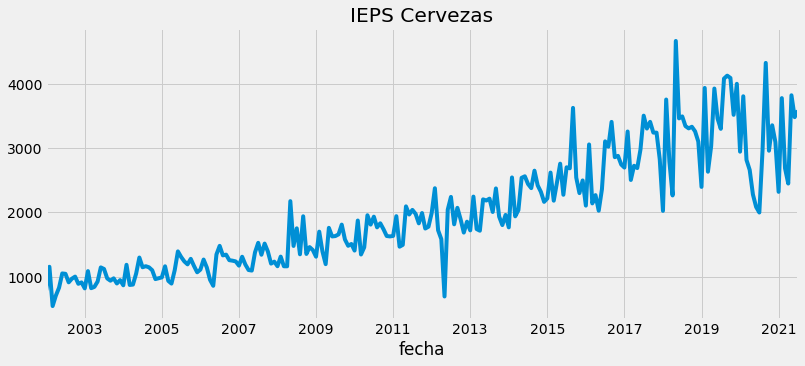

In [3]:
ieps_cervezasp=df['ieps_cervezas']
ieps_cervezas=ieps_cervezasp.dropna()
ieps_cervezas.plot(figsize=(12,5))
plt.title('IEPS Cervezas')
plt.show()

El histograma y la correspondiente función de densidad se ven como sigue:

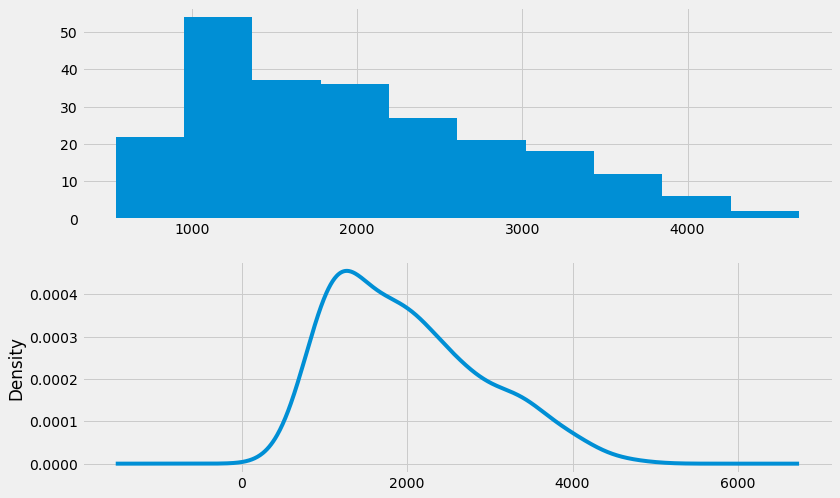

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,8))
ieps_cervezas.hist(ax=ax1)
ieps_cervezas.plot(kind='kde',ax=ax2)
plt.show()

La descomposición de esta serie en sus componentes de tendencia, estacional y residuales, se ve como sigue:

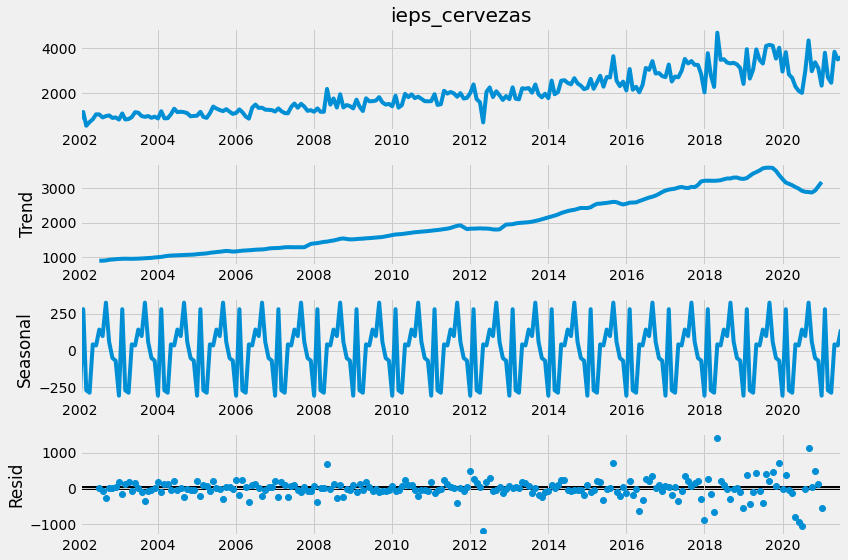

In [5]:
decomposition = seasonal_decompose(ieps_cervezas, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show()

Los correlogramas, se ven como sigue:

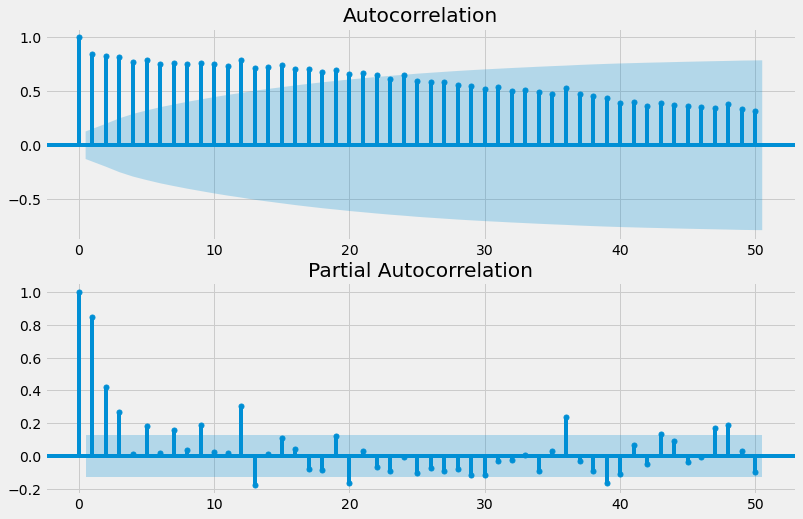

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=False, sharey=False)
ax1 = plot_acf(ieps_cervezas, lags=50, ax=ax1)
ax2 = plot_pacf(ieps_cervezas, lags=50, ax=ax2)
plt.show()

Aquí aplicó la prueba Dickey-Fuller que falla en rechazar que la serie tenga raíz unitaria. Con ello concluyó que la serie tiene raíz unitaria.

In [7]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ieps_cervezas)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.236237
p-value                          0.934062
#Lags Used                      12.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


Generó la serie en primeras diferencias:

In [8]:
df_diff = ieps_cervezas.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2021-03-01    -102.2
2021-04-01     -81.0
2021-05-01    1758.0
2021-06-01    -145.3
2021-07-01     188.4
Name: ieps_cervezas, dtype: float64

Y para la serie en primeras diferencias, rechazó la hipotesis de que la serie tiene raíz unitaria, en favor de la hipotesis que la serie es estacionaria. En otras palabras, puedo concluir que la serie en primeras diferencias sí es estacionaria.

In [9]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.233054e+00
p-value                        4.900097e-08
#Lags Used                     1.500000e+01
Number of Observations Used    2.060000e+02
Critical Value (1%)           -3.462499e+00
Critical Value (5%)           -2.875675e+00
Critical Value (10%)          -2.574304e+00
dtype: float64


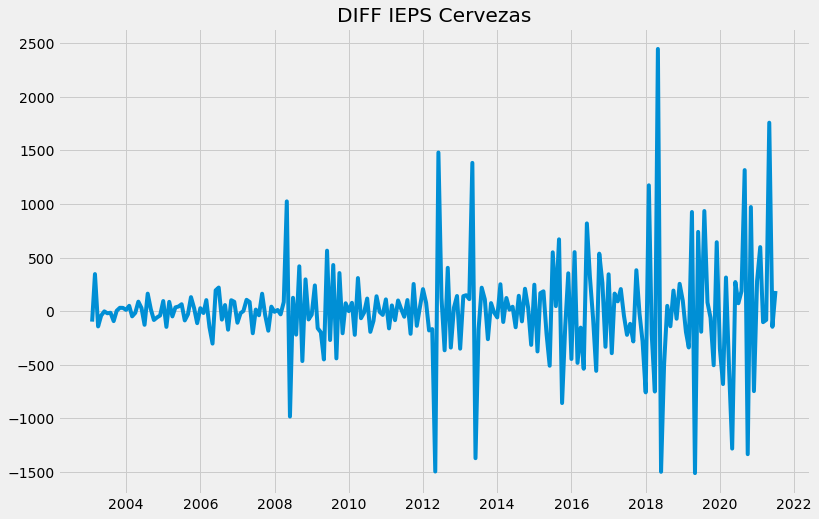

In [10]:
plt.plot(df_diff)
plt.title('DIFF IEPS Cervezas')
#plt.savefig('diffplot')
plt.show()

Aquí los correlogramas de la serie en primeras diferencias:

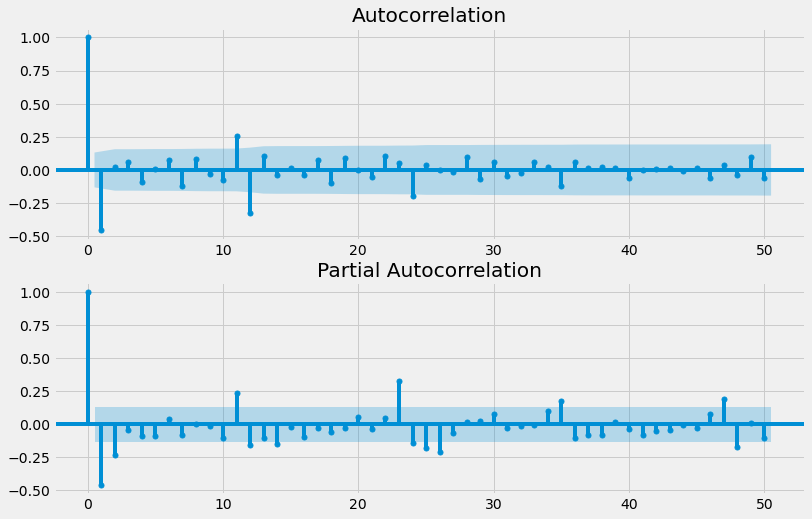

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

Con este comando, automáticamente se evaluan diferentes propuestas de modelos ARIMA, seleccionando el mejor modelo:

In [13]:
model = pm.auto_arima(ieps_cervezas, d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=9, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3292.063, Time=1.03 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3360.414, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3291.291, Time=0.67 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3217.454, Time=0.79 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3296.440, Time=0.85 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3219.324, Time=2.63 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3219.155, Time=6.81 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3270.511, Time=2.43 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=11.57 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3290.610, Time=0.68 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3213.099, Time=3.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3298.430, Time=1.52 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3214.994, Time=2.11 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3214.897, Time=10.65 sec
 ARIMA(1,1,1)(1,1,0)[1

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  235
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1601.550
Date:                            Tue, 07 Sep 2021   AIC                           3213.099
Time:                                    15:48:03   BIC                           3230.113
Sample:                                         0   HQIC                          3219.968
                                            - 235                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1059      0.660      0.161      0.872      -1.187       1.399
ar.L1          0.2516      0.049      5.177      0.000       0.156       0.347
ma.L1         -0.9086      0.024    -37.853      0.000      -0.956      -0.862
ma.S.L12      -0.7614      0.044    -17.459      0.000      -0.847      -0.676
sigma2      1.031e+05   5163.368     19.973      0.000     9.3e+04    1.13e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               825.59
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               9.40   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A diferencia de la ocasión anterior, ahora trabajaré con la serie completa con el modelo SARIMA que resultó, y entrenaré dicha especificación para obtener los mejores coeficientes:

In [15]:
model = SARIMAX(ieps_cervezas,order=(1,1,1),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      ieps_cervezas   No. Observations:                  235
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1601.564
Date:                            Tue, 07 Sep 2021   AIC                           3211.128
Time:                                    15:48:26   BIC                           3224.738
Sample:                                01-01-2002   HQIC                          3216.623
                                     - 07-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2509      0.044      5.750      0.000       0.165       0.336
ma.L1         -0.9078      0.024    -37.752      0.000      -0.955      -0.861
ma.S.L12      -0.7610      0.041    -18.506      0.000      -0.842      -0.680
sigma2      1.032e+05   5026.424     20.523      0.000    9.33e+04    1.13e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               825.72
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               9.37   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Y los resultados se ven bastante prometedores en esta parte de prueba:

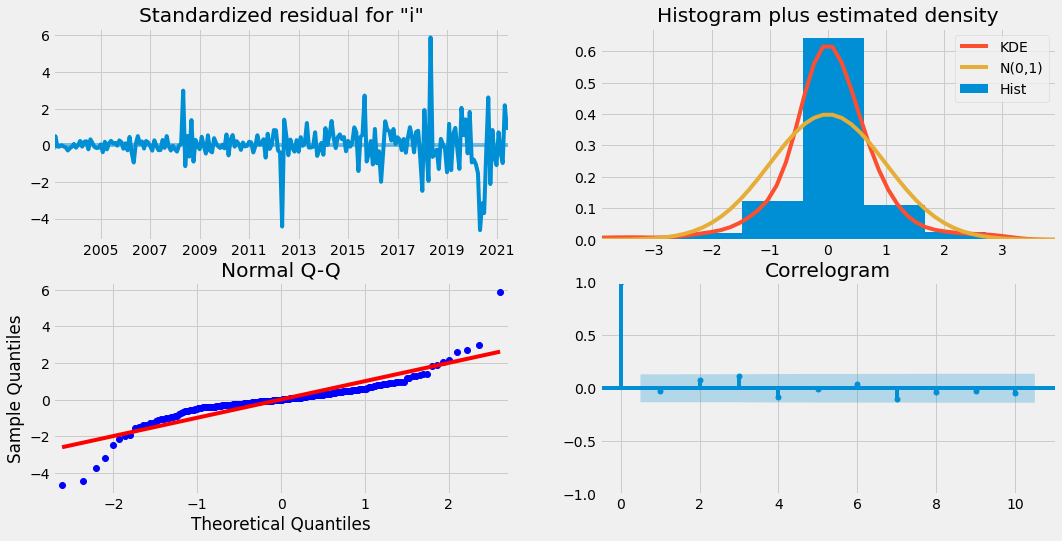

In [16]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics1')
plt.show()

Calculo y gráfico los pronósticos para toda la serie

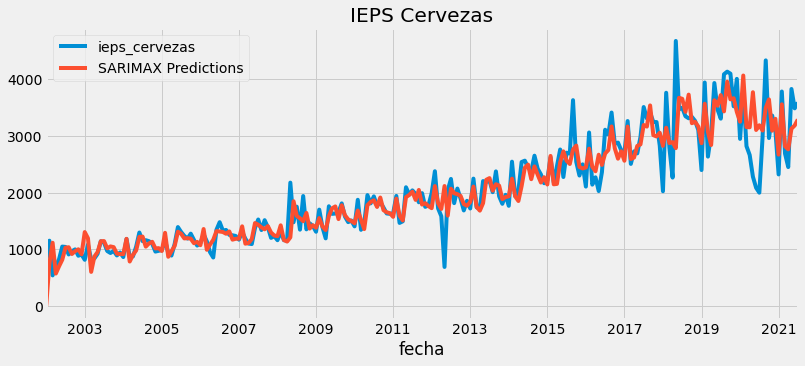

In [17]:
predictions = results.predict(start=0, end=len(ieps_cervezas)-1, dynamic=False, typ='levels').rename('SARIMAX Predictions')
title = 'IEPS Cervezas'
ax = ieps_cervezas.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

Calculo los estadísticos del modelo:

In [18]:
r2_score(ieps_cervezas, predictions)
evaluation_results = pd.DataFrame({'r2_score': r2_score(ieps_cervezas, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(ieps_cervezas, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(ieps_cervezas, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - ieps_cervezas)/np.abs(ieps_cervezas))*100 
evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0  0.870524           197.265383       103711.466506   

   mean_absolute_percentage_error  
0                        10.61201

Y hago los pronósticos hacia adelante. Esta es la parte que más me interesa para cada serie.

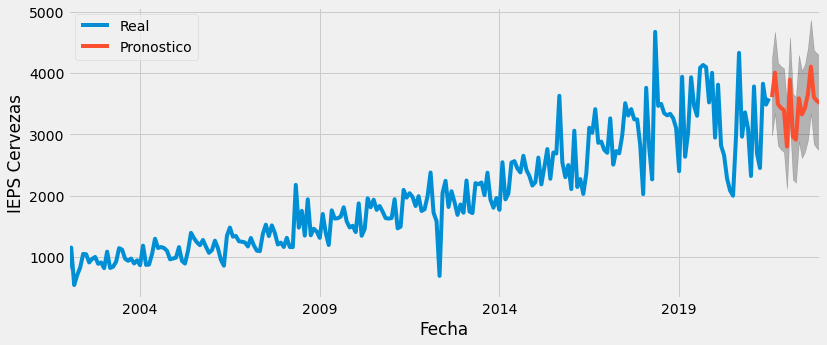

In [19]:
pred_f = results.get_forecast(steps=17)
pred_ci = pred_f.conf_int()
ax = ieps_cervezas.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IEPS Cervezas')
plt.legend()
plt.show()

Y guardo los resultados en un csv para su posterior uso.

In [20]:
x=pred_f.predicted_mean
x.to_csv('arima_iepscervezas.csv')

### 4.2 IEPS Bebidas

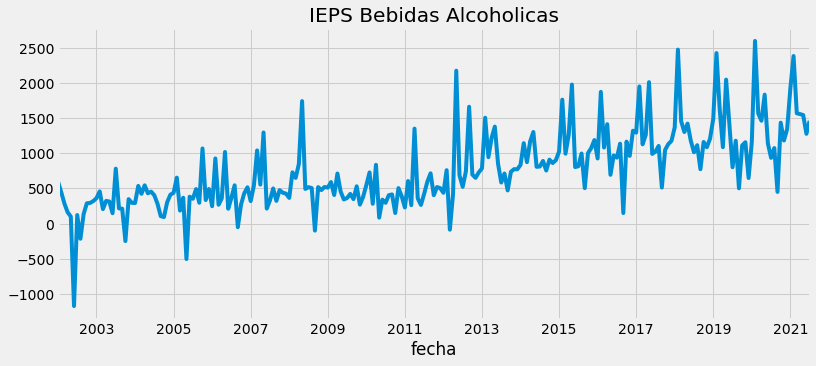

In [21]:
ieps_bebidasp=df['ieps_bebidas']
ieps_bebidas=ieps_bebidasp.dropna()
ieps_bebidas.plot(figsize=(12,5))
plt.title('IEPS Bebidas Alcoholicas')
plt.show()

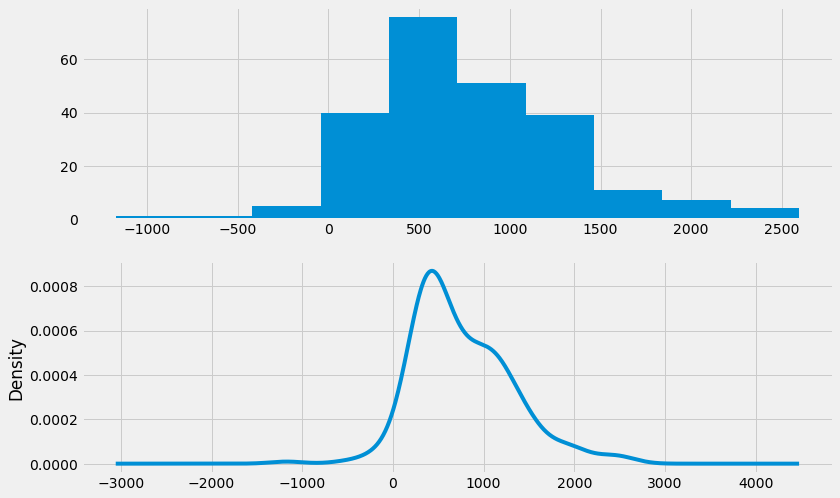

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,8))
ieps_bebidas.hist(ax=ax1)
ieps_bebidas.plot(kind='kde',ax=ax2)
plt.show()

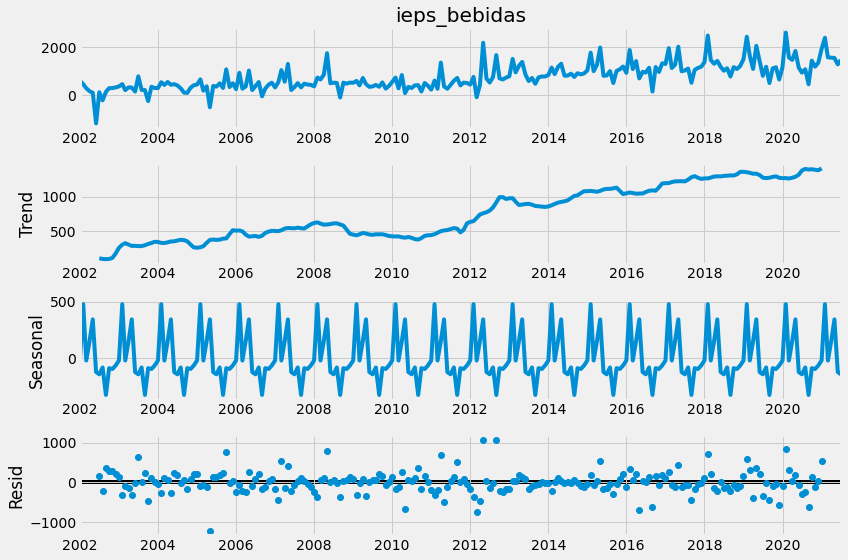

In [23]:
decomposition = seasonal_decompose(ieps_bebidas, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show();

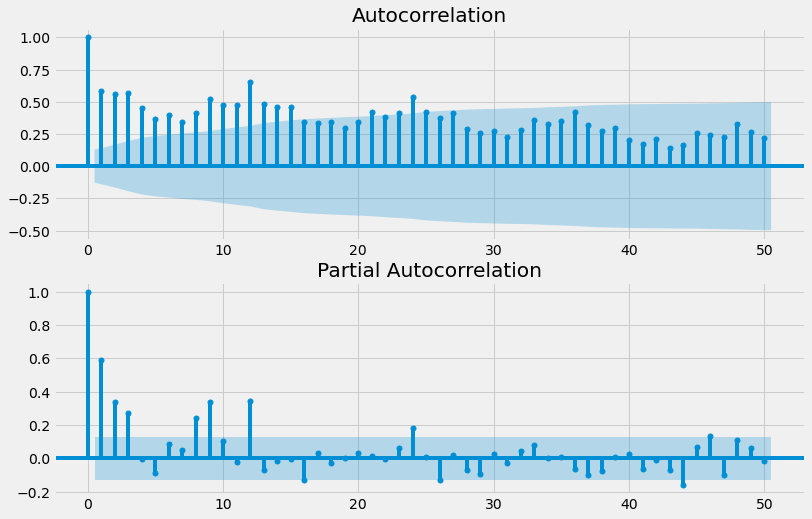

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=False, sharey=False)
ax1 = plot_acf(ieps_bebidas, lags=50, ax=ax1)
ax2 = plot_pacf(ieps_bebidas, lags=50, ax=ax2)
plt.show()

In [25]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ieps_bebidas)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.640294
p-value                          0.861615
#Lags Used                      11.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


In [26]:
df_diff = ieps_bebidas.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2021-03-01    216.5
2021-04-01     92.4
2021-05-01   -385.1
2021-06-01    425.2
2021-07-01    391.1
Name: ieps_bebidas, dtype: float64

In [27]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.181862e+00
p-value                        6.426360e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


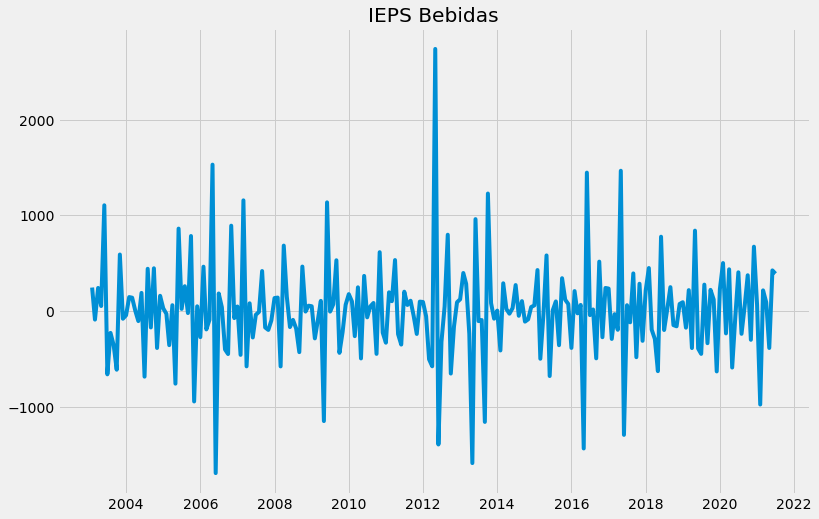

In [28]:
plt.plot(df_diff)
plt.title('IEPS Bebidas')
#plt.savefig('diffplot')
plt.show()

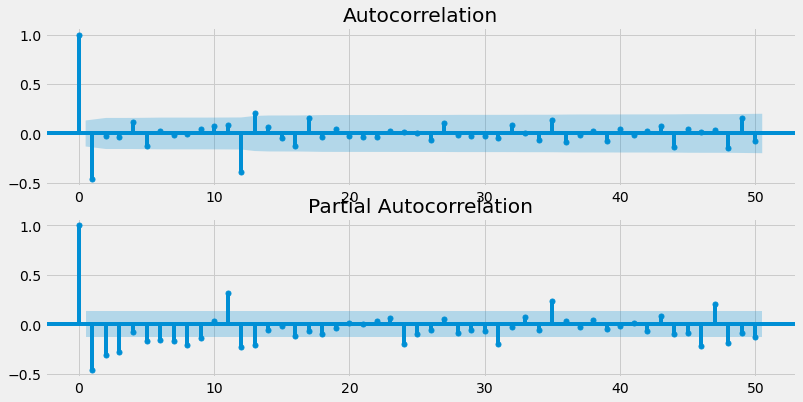

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [30]:
model = pm.auto_arima(ieps_bebidas, d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=9, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3332.188, Time=2.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3404.734, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3305.001, Time=1.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3212.165, Time=1.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3213.208, Time=5.77 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3240.983, Time=0.75 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=6.38 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3333.350, Time=1.03 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3213.544, Time=2.89 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=3274.705, Time=0.83 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=4.10 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=3

In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  235
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1602.083
Date:                            Tue, 07 Sep 2021   AIC                           3212.165
Time:                                    15:49:49   BIC                           3225.776
Sample:                                         0   HQIC                          3217.661
                                            - 235                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0105      0.648      0.016      0.987      -1.260       1.281
ma.L1         -0.9286      0.031    -30.346      0.000      -0.989      -0.869
ma.S.L12      -0.7138      0.045    -16.018      0.000      -0.801      -0.626
sigma2      1.048e+05   6679.813     15.692      0.000    9.17e+04    1.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):               191.86
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.86
Prob(H) (two-sided):                  0.16   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
model = SARIMAX(ieps_bebidas,order=(0,1,1),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       ieps_bebidas   No. Observations:                  235
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1602.083
Date:                            Tue, 07 Sep 2021   AIC                           3210.166
Time:                                    15:50:06   BIC                           3220.374
Sample:                                01-01-2002   HQIC                          3214.287
                                     - 07-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9286      0.031    -30.443      0.000      -0.988      -0.869
ma.S.L12      -0.7138      0.042    -16.825      0.000      -0.797      -0.631
sigma2      1.048e+05   6200.228     16.907      0.000    9.27e+04    1.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):               191.84
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.86
Prob(H) (two-sided):                  0.16   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

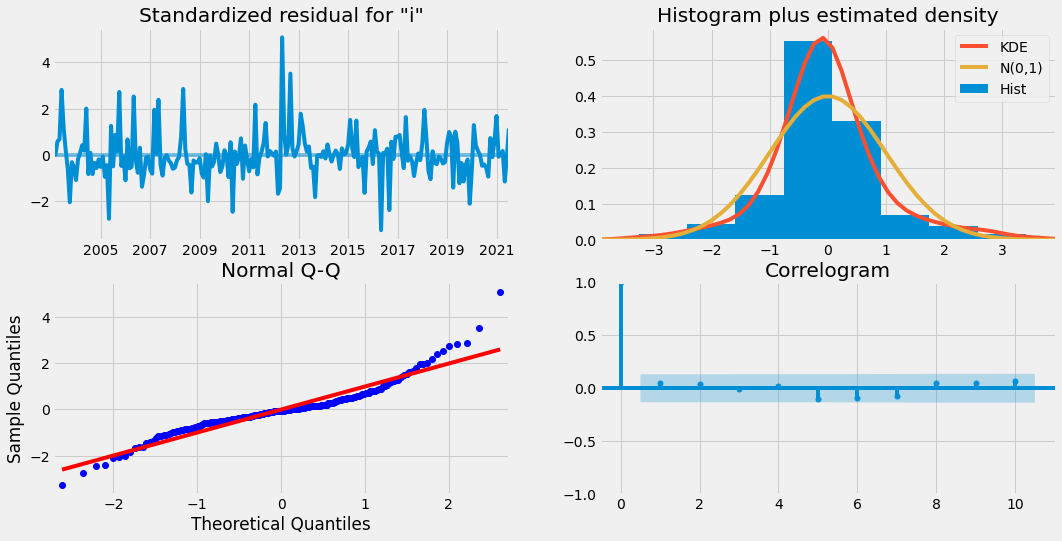

In [33]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

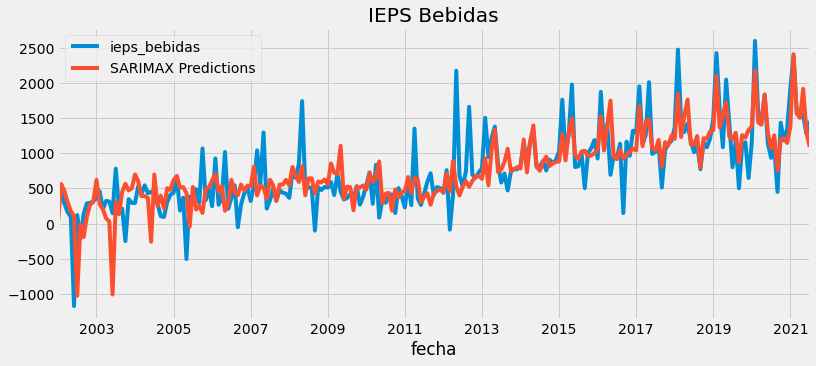

In [34]:
predictions = results.predict(start=0, end=len(ieps_bebidas)-1, dynamic=False, typ='levels').rename('SARIMAX Predictions')
title = 'IEPS Bebidas'
ax = ieps_bebidas.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [35]:
r2_score(ieps_bebidas, predictions)
evaluation_results = pd.DataFrame({'r2_score': r2_score(ieps_bebidas, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(ieps_bebidas, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(ieps_bebidas, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - ieps_bebidas)/np.abs(ieps_bebidas))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0   0.59614           228.439368       119415.095601   

   mean_absolute_percentage_error  
0                       59.102953

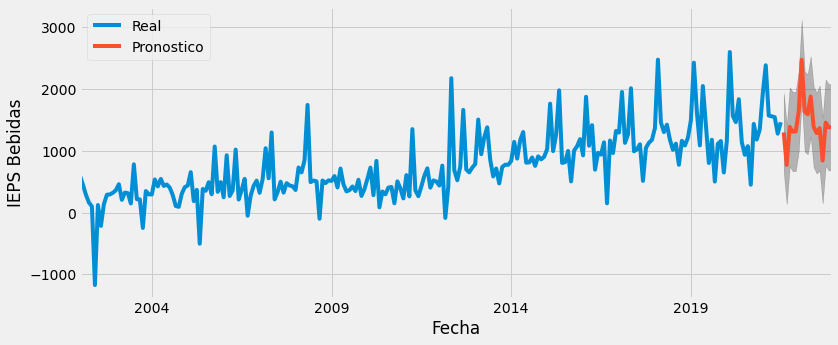

In [36]:
pred_f = results.get_forecast(steps=17)
pred_ci = pred_f.conf_int()
ax = ieps_bebidas.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IEPS Bebidas')
plt.legend()
plt.show()

In [37]:
x=pred_f.predicted_mean
x.to_csv('arima_iepsbebidas.csv')

### 4.3 IEPS Tabacos

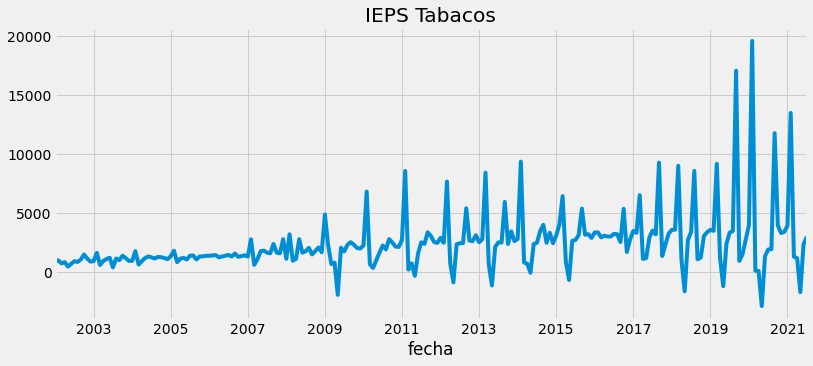

In [38]:
ieps_tabacosp=df['ieps_tabacos']
ieps_tabacos=ieps_tabacosp.dropna()
ieps_tabacos.plot(figsize=(12,5))
plt.title('IEPS Tabacos')
plt.show()

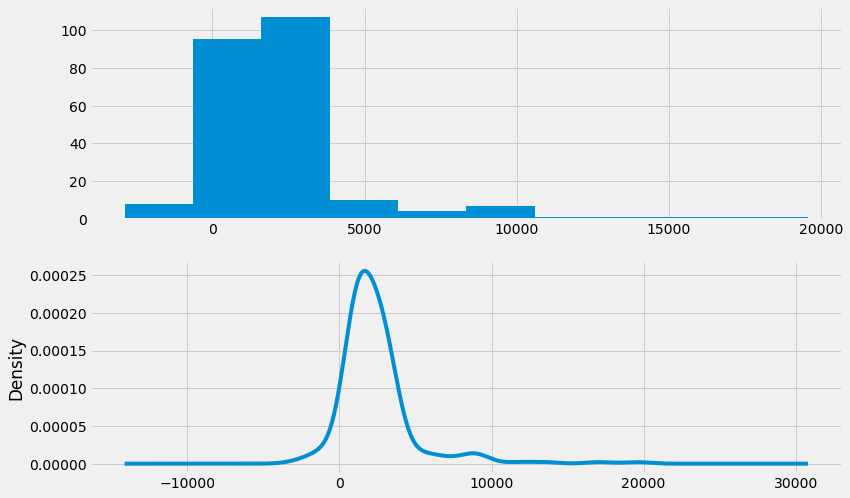

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,8))
ieps_tabacos.hist(ax=ax1)
ieps_tabacos.plot(kind='kde',ax=ax2)
plt.show()

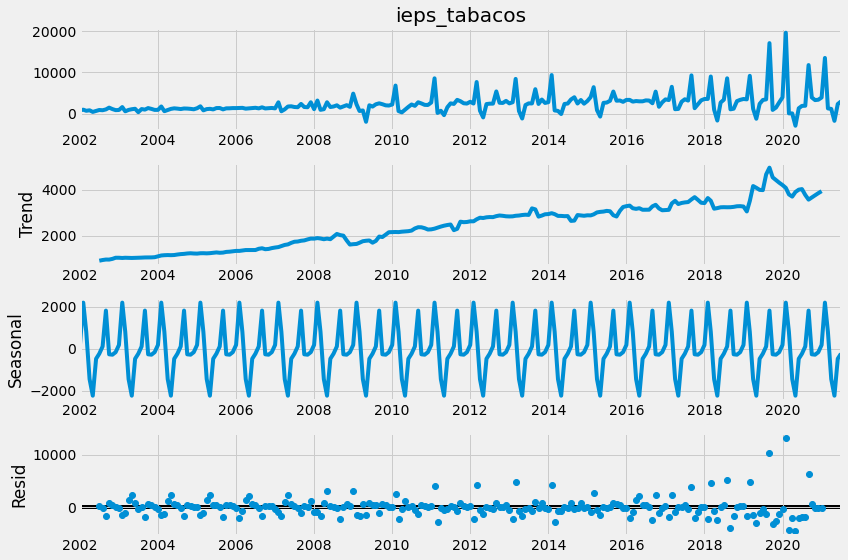

In [40]:
decomposition = seasonal_decompose(ieps_tabacos, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show();

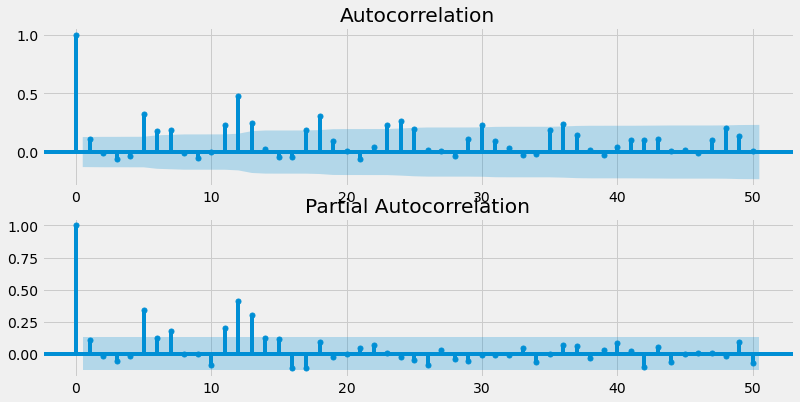

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(ieps_tabacos, lags=50, ax=ax1)
ax2 = plot_pacf(ieps_tabacos, lags=50, ax=ax2)
plt.show()

In [42]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ieps_tabacos)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.809903
p-value                          0.816196
#Lags Used                      14.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


In [43]:
df_diff = ieps_tabacos.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2021-03-01    7290.1
2021-04-01    -108.1
2021-05-01      96.4
2021-06-01    -159.0
2021-07-01      52.4
Name: ieps_tabacos, dtype: float64

In [44]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.605603e+00
p-value                        6.568797e-09
#Lags Used                     1.500000e+01
Number of Observations Used    2.060000e+02
Critical Value (1%)           -3.462499e+00
Critical Value (5%)           -2.875675e+00
Critical Value (10%)          -2.574304e+00
dtype: float64


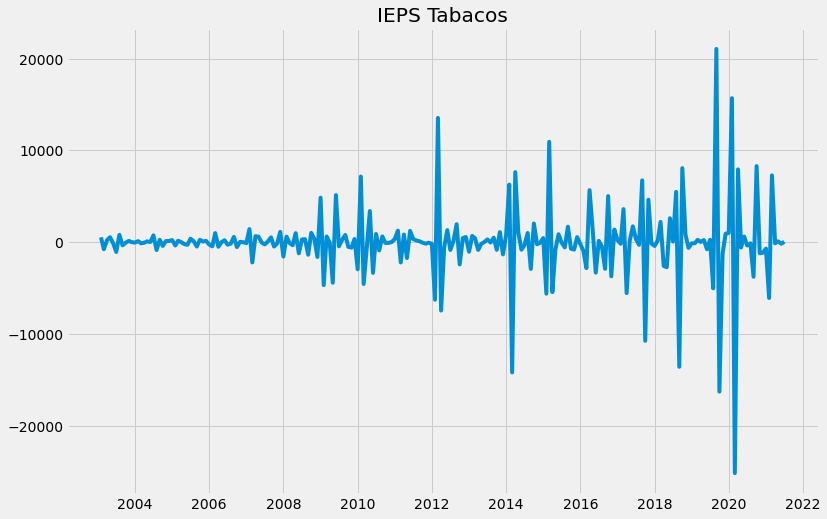

In [45]:
plt.plot(df_diff)
plt.title('IEPS Tabacos')
#plt.savefig('diffplot')
plt.show()

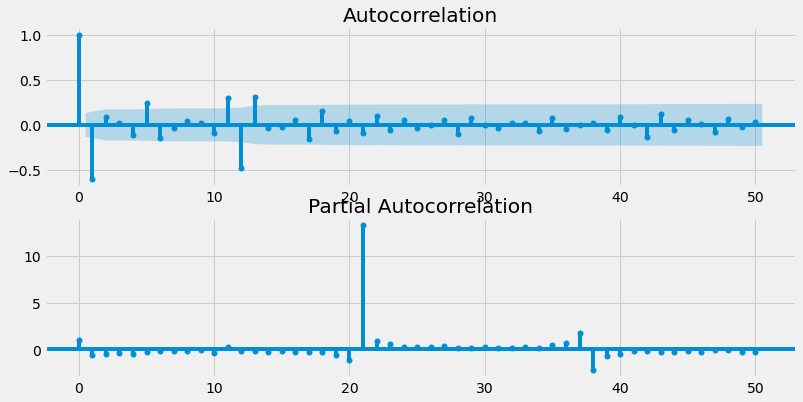

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [47]:
model = pm.auto_arima(ieps_tabacos, d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=9, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=4232.130, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4315.426, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4172.795, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4217.634, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4158.576, Time=4.11 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=4148.925, Time=5.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=4147.628, Time=1.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4146.071, Time=3.01 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=4147.468, Time=2.92 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=4149.270, Time=9.41 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4230.261, Time=1.66 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=4110.902, Time=2.34 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=4173.308, Time=0.14 sec
 ARIMA(2,1,0)(1,1,1)[12]

In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  235
Model:             SARIMAX(5, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2001.517
Date:                            Tue, 07 Sep 2021   AIC                           4021.033
Time:                                    15:54:21   BIC                           4051.657
Sample:                                         0   HQIC                          4033.397
                                            - 235                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.4507      7.748     -0.445      0.656     -18.637      11.735
ar.L1         -0.3638      0.086     -4.210      0.000      -0.533      -0.194
ar.L2         -0.2424      0.140     -1.728      0.084      -0.517       0.033
ar.L3         -0.1844      0.113     -1.638      0.101      -0.405       0.036
ar.L4         -0.1473      0.092     -1.605      0.109      -0.327       0.033
ar.L5          0.1189      0.069      1.727      0.084      -0.016       0.254
ma.L1         -0.9559      0.059    -16.217      0.000      -1.071      -0.840
ma.S.L12      -0.5810      0.085     -6.864      0.000      -0.747      -0.415
sigma2      5.241e+06   4.09e+05     12.814      0.000    4.44e+06    6.04e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2768.07
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              29.07   Skew:                             2.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
model = SARIMAX(ieps_tabacos,order=(5,1,1),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       ieps_tabacos   No. Observations:                  235
Model:             SARIMAX(5, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1992.029
Date:                            Tue, 07 Sep 2021   AIC                           4000.057
Time:                                    15:54:42   BIC                           4027.279
Sample:                                01-01-2002   HQIC                          4011.047
                                     - 07-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3616      0.052     -6.983      0.000      -0.463      -0.260
ar.L2         -0.2396      0.097     -2.471      0.013      -0.430      -0.050
ar.L3         -0.1832      0.073     -2.525      0.012      -0.325      -0.041
ar.L4         -0.1381      0.055     -2.508      0.012      -0.246      -0.030
ar.L5          0.1344      0.028      4.750      0.000       0.079       0.190
ma.L1         -1.0000      0.041    -24.642      0.000      -1.080      -0.920
ma.S.L12      -0.6304      0.051    -12.316      0.000      -0.731      -0.530
sigma2       3.49e+06   1.16e-08      3e+14      0.000    3.49e+06    3.49e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2670.60
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              30.65   Skew:                             2.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.74e+31. Standard errors may be unstable.
"""

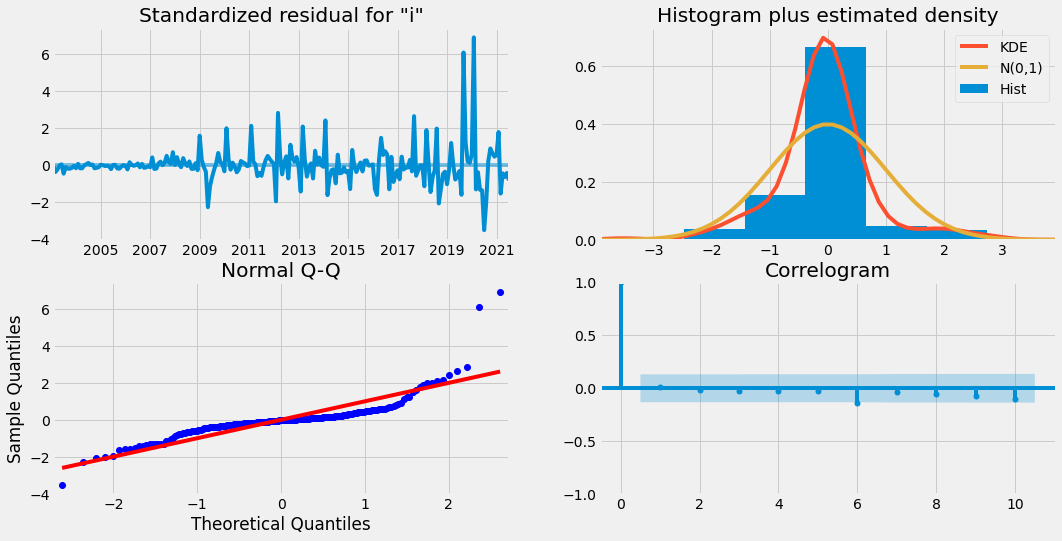

In [50]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

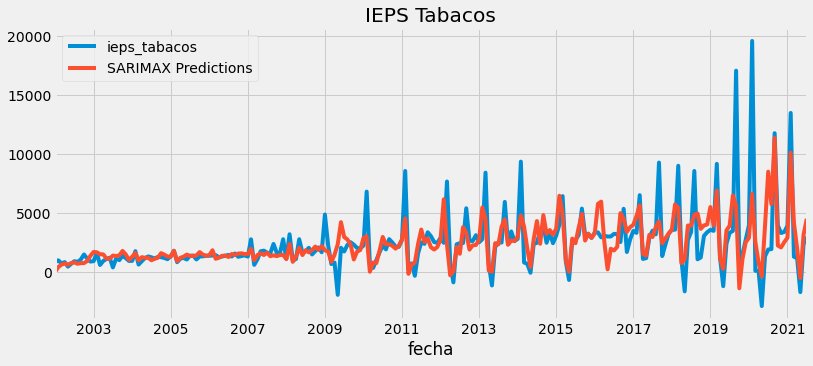

In [51]:
predictions = results.predict(start=0, end=len(ieps_tabacos)-1, dynamic=False, typ='levels').rename('SARIMAX Predictions')
title = 'IEPS Tabacos'
ax = ieps_tabacos.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [52]:
r2_score(ieps_tabacos, predictions)
evaluation_results = pd.DataFrame({'r2_score': r2_score(ieps_tabacos, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(ieps_tabacos, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(ieps_tabacos, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - ieps_tabacos)/np.abs(ieps_tabacos))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0  0.481151          1002.682835        3.331676e+06   

   mean_absolute_percentage_error  
0                       61.801752

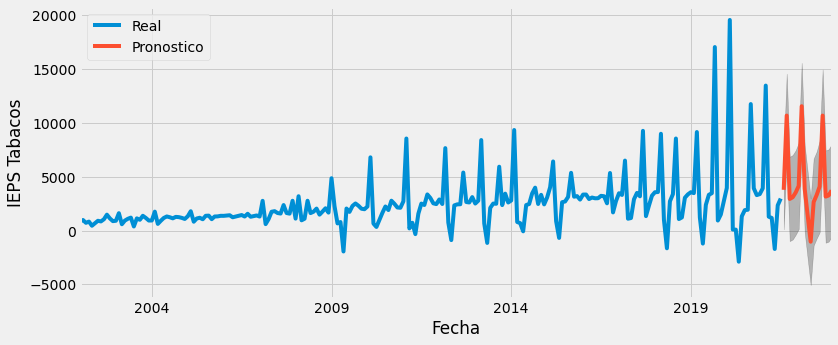

In [53]:
pred_f = results.get_forecast(steps=17)
pred_ci = pred_f.conf_int()
ax = ieps_tabacos.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IEPS Tabacos')
plt.legend()
plt.show()

In [54]:
x=pred_f.predicted_mean
x.to_csv('arima_iepstabacos.csv')

### 4.4 IEPS Gasolinas y Diesel

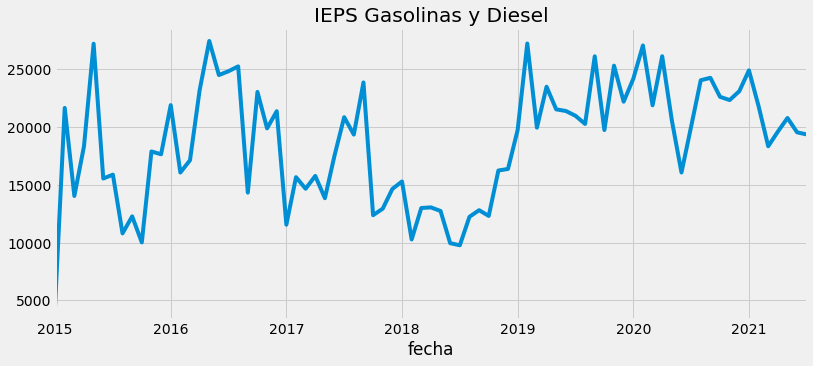

In [55]:
ieps_gasp=df['ieps_gas']
ieps_gas=ieps_gasp.dropna()
ieps_gas.plot(figsize=(12,5))
plt.title('IEPS Gasolinas y Diesel')
plt.show()

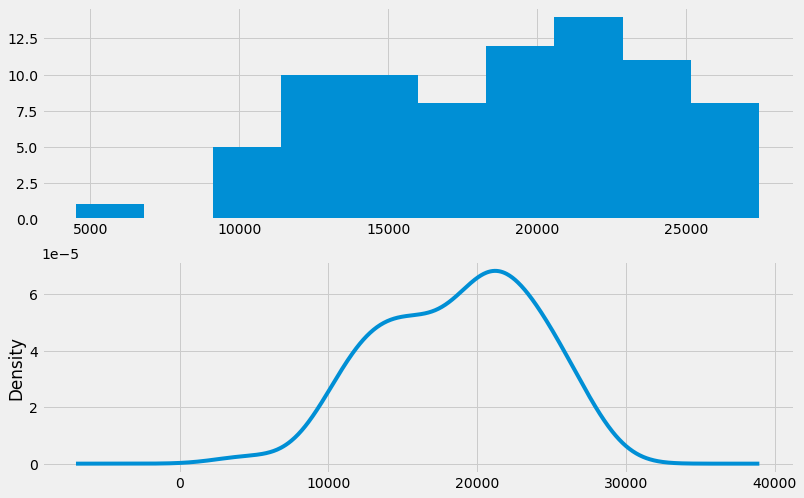

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,8))
ieps_gas.hist(ax=ax1)
ieps_gas.plot(kind='kde',ax=ax2)
plt.show()

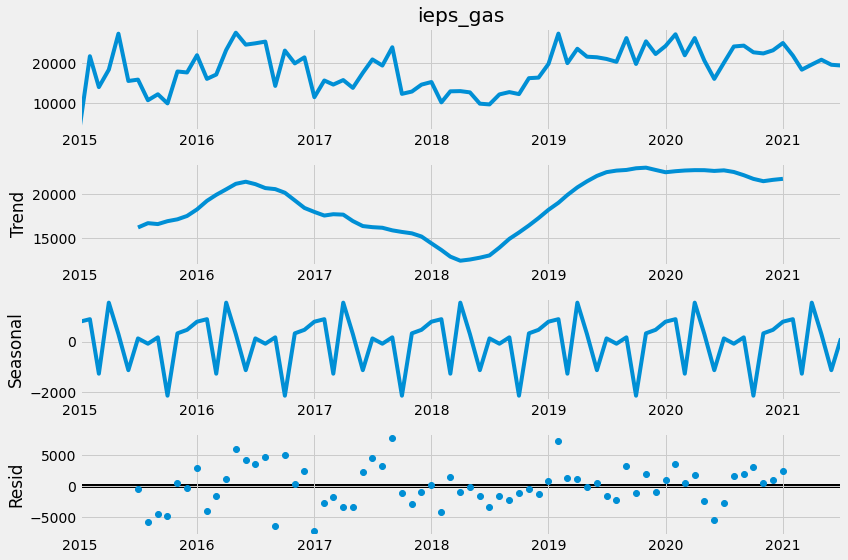

In [57]:
decomposition = seasonal_decompose(ieps_gas, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show();

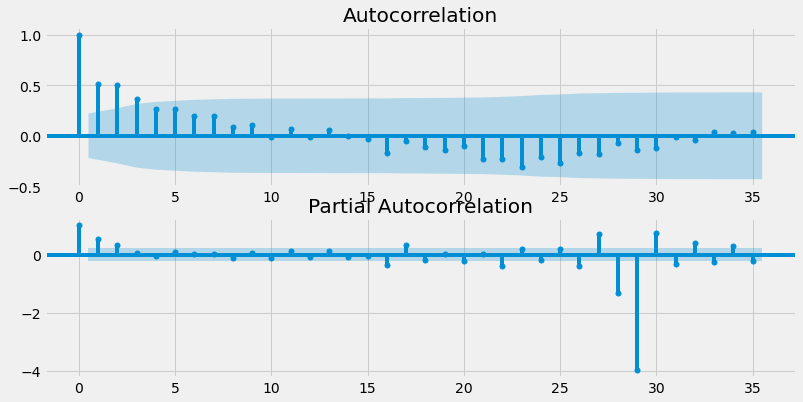

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(ieps_gas, lags=35, ax=ax1)
ax2 = plot_pacf(ieps_gas, lags=35, ax=ax2)
plt.show()

In [59]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ieps_gas)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.891800
p-value                         0.046310
#Lags Used                      1.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


In [60]:
df_diff = ieps_gas.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2021-03-01    1701.7
2021-04-01   -2978.6
2021-05-01    6731.5
2021-06-01    3275.9
2021-07-01   -4156.1
Name: ieps_gas, dtype: float64

In [61]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -3.001697
p-value                         0.034736
#Lags Used                     11.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


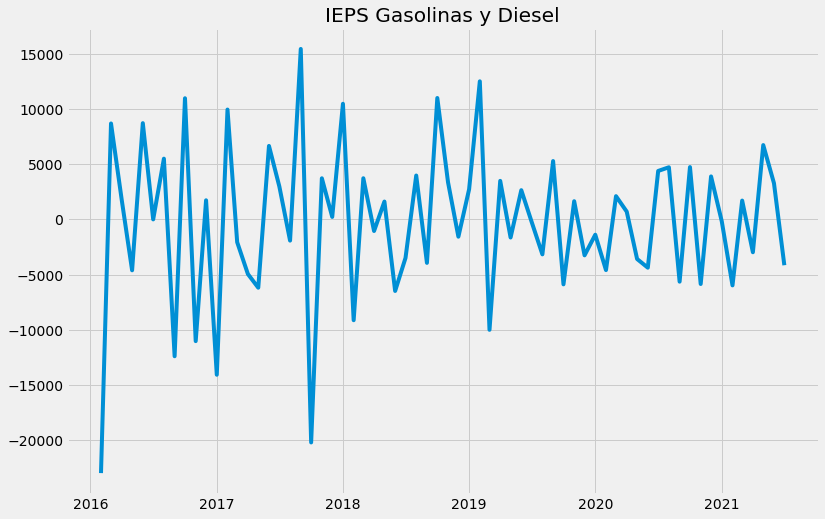

In [62]:
plt.plot(df_diff)
plt.title('IEPS Gasolinas y Diesel')
#plt.savefig('diffplot')
plt.show()

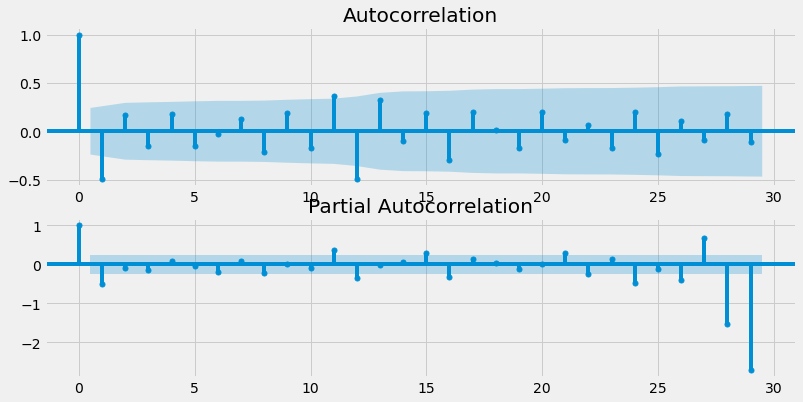

In [63]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=29, ax=ax1)
ax2 = plot_pacf(df_diff, lags=29, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [64]:
model = pm.auto_arima(ieps_gas, seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=12, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1548.389, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1547.591, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1541.992, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1541.984, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1547.591, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1536.868, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1538.474, Time=0.56 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1540.352, Time=1.41 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1538.959, Time=0.89 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1538.860, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1540.497, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1536.868, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 4.116 seconds


In [65]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -765.434
Date:                Tue, 07 Sep 2021   AIC                           1536.868
Time:                        15:55:47   BIC                           1543.938
Sample:                             0   HQIC                          1539.699
                                 - 79                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    218.1468    319.401      0.683      0.495    -407.868     844.162
ma.L1         -0.4324      0.114     -3.777      0.000      -0.657      -0.208
sigma2      1.931e+07      2e+06      9.675      0.000    1.54e+07    2.32e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                33.84
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
model = SARIMAX(ieps_gas,order=(0,1,1),seasonal_order=(0,0,0,12))
results = model.fit()
results.summary()

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ieps_gas   No. Observations:                   79
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -765.604
Date:                Tue, 07 Sep 2021   AIC                           1535.209
Time:                        15:55:56   BIC                           1539.922
Sample:                    01-01-2015   HQIC                          1537.096
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4286      0.106     -4.043      0.000      -0.636      -0.221
sigma2      1.957e+07   1.98e+06      9.865      0.000    1.57e+07    2.35e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                32.72
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

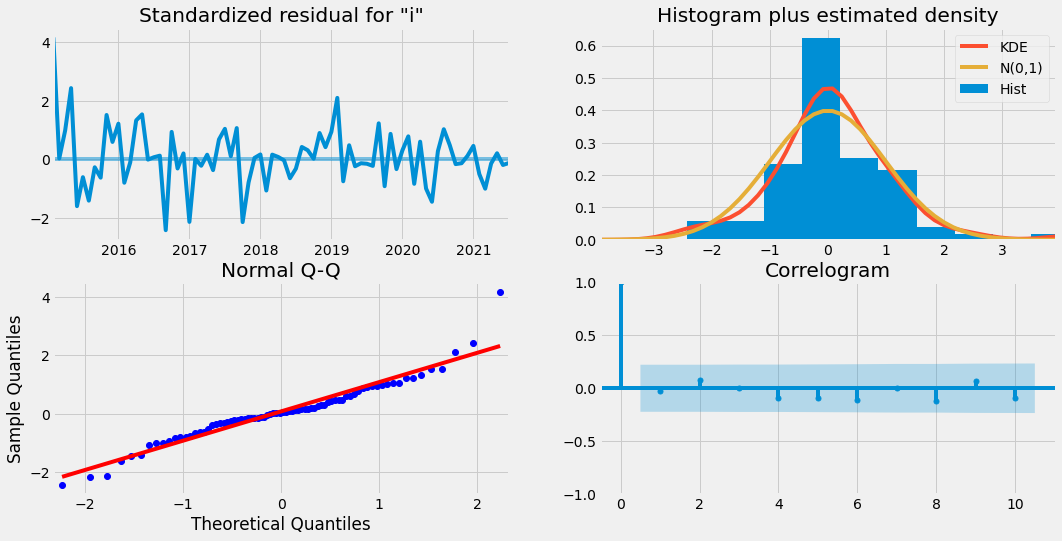

In [67]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

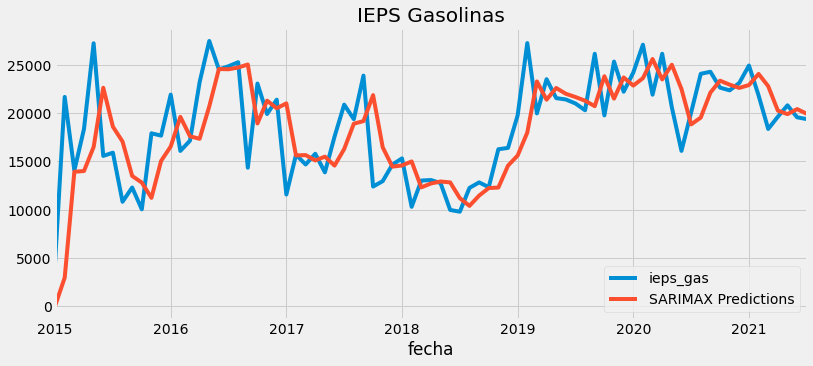

In [68]:
predictions = results.predict(start=0, end=len(ieps_gas)-1, dynamic=False, typ='levels').rename('SARIMAX Predictions')
title = 'IEPS Gasolinas'
ax = ieps_gas.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [69]:
r2_score(ieps_gas, predictions)
evaluation_results = pd.DataFrame({'r2_score': r2_score(ieps_gas, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(ieps_gas, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(ieps_gas, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - ieps_gas)/np.abs(ieps_gas))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0   0.23939           3125.89664        1.978774e+07   

   mean_absolute_percentage_error  
0                       18.591471

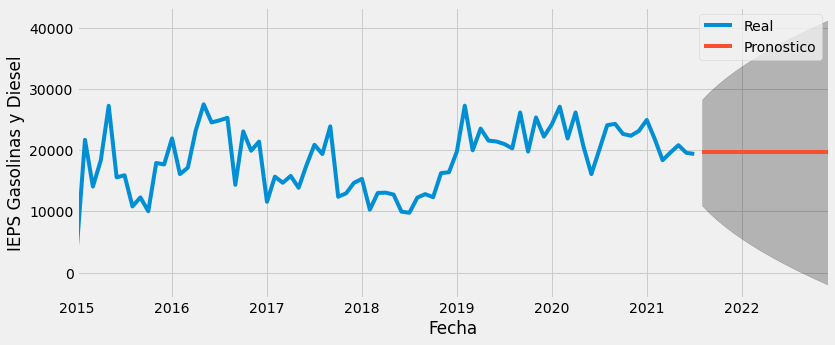

In [70]:
pred_f = results.get_forecast(steps=17)
pred_ci = pred_f.conf_int()
ax = ieps_gas.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IEPS Gasolinas y Diesel')
plt.legend()
plt.show()

In [71]:
x=pred_f.predicted_mean
x.to_csv('arima_iepsgas.csv')

### 4.5 IEPS Bebidas Saborizadas

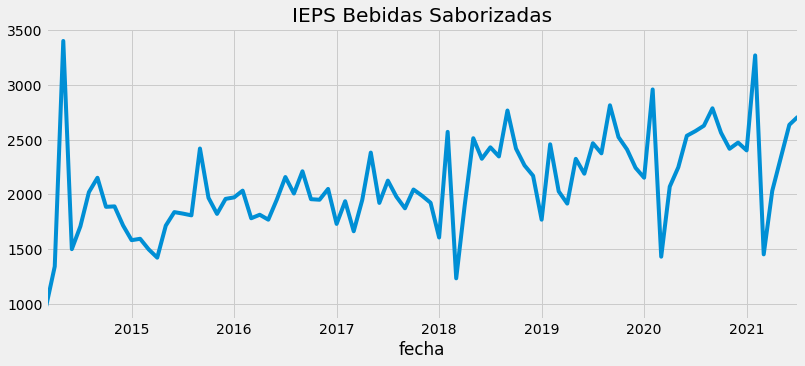

In [72]:
ieps_bebidassabp=df['ieps_bebidassab']
ieps_bebidassab=ieps_bebidassabp.dropna()
ieps_bebidassab.plot(figsize=(12,5))
plt.title('IEPS Bebidas Saborizadas')
plt.show()

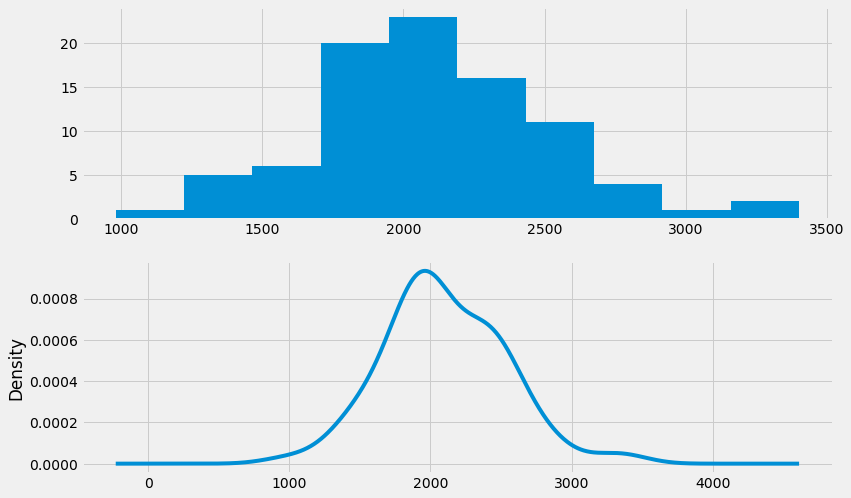

In [73]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,8))
ieps_bebidassab.hist(ax=ax1)
ieps_bebidassab.plot(kind='kde',ax=ax2)
plt.show()

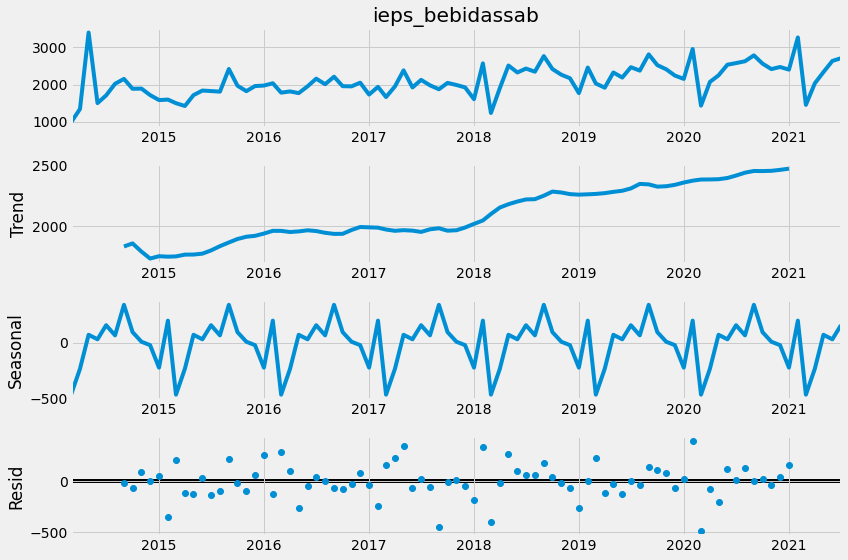

In [74]:
decomposition = seasonal_decompose(ieps_bebidassab, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show();

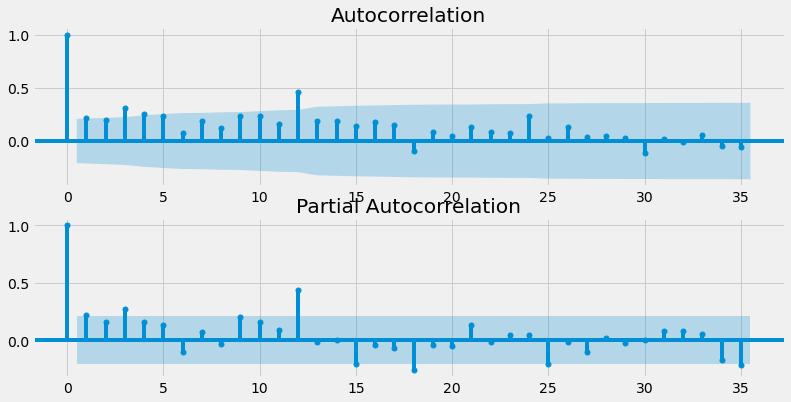

In [75]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(ieps_bebidassab, lags=35, ax=ax1)
ax2 = plot_pacf(ieps_bebidassab, lags=35, ax=ax2)
plt.show()

In [76]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ieps_bebidassab)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -0.195569
p-value                         0.939048
#Lags Used                     11.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


In [77]:
df_diff = ieps_bebidassab.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2021-03-01   -289.6
2021-04-01    -59.8
2021-05-01    125.6
2021-06-01     13.2
2021-07-01     31.4
Name: ieps_bebidassab, dtype: float64

In [78]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.610010e+00
p-value                        6.412182e-09
#Lags Used                     4.000000e+00
Number of Observations Used    7.100000e+01
Critical Value (1%)           -3.526005e+00
Critical Value (5%)           -2.903200e+00
Critical Value (10%)          -2.588995e+00
dtype: float64


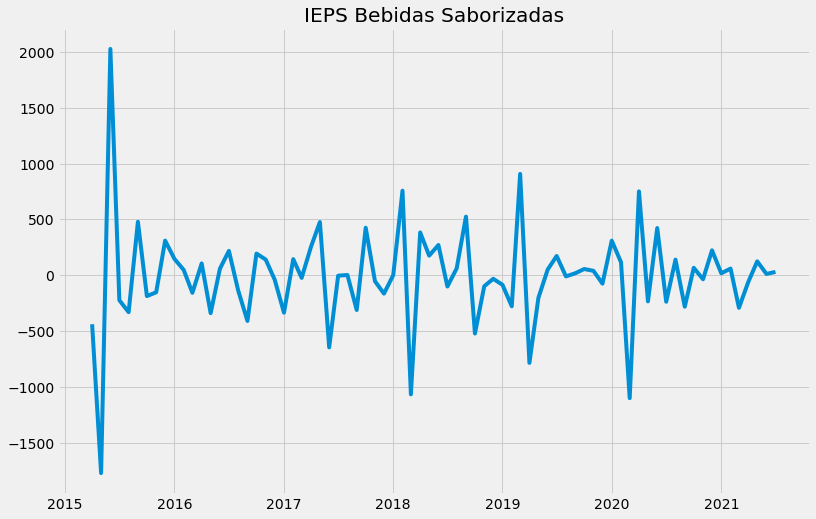

In [79]:
plt.plot(df_diff)
plt.title('IEPS Bebidas Saborizadas')
#plt.savefig('diffplot')
plt.show()

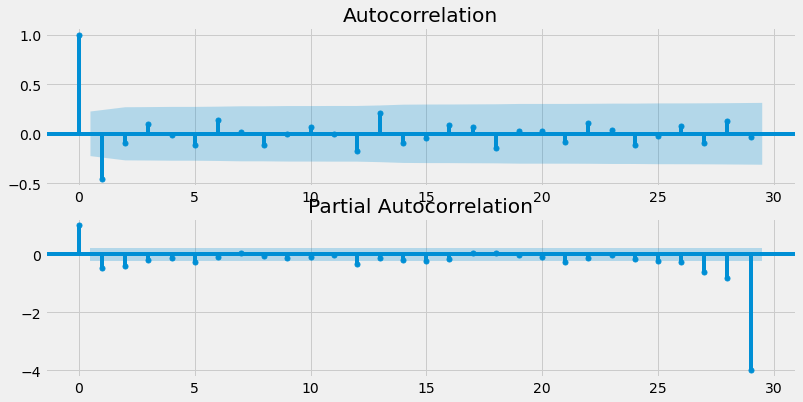

In [80]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=29, ax=ax1)
ax2 = plot_pacf(df_diff, lags=29, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [81]:
model = pm.auto_arima(ieps_bebidassab, d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=9, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1145.094, Time=1.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1151.816, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1133.041, Time=0.63 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1136.342, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1125.663, Time=0.88 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1126.894, Time=1.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1129.442, Time=1.83 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1142.042, Time=1.23 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1112.596, Time=5.75 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1117.424, Time=1.23 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=1114.009, Time=8.55 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=1115.049, Time=1.21 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1108.128, Time=4.21 sec
 ARIMA(3,1,0)(1,1,0)[12]

In [82]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   89
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -547.064
Date:                            Tue, 07 Sep 2021   AIC                           1108.128
Time:                                    15:57:42   BIC                           1124.443
Sample:                                         0   HQIC                          1114.648
                                             - 89                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.8798     50.966      0.174      0.862     -91.013     108.772
ar.L1         -0.8400      0.123     -6.809      0.000      -1.082      -0.598
ar.L2         -0.7130      0.126     -5.673      0.000      -0.959      -0.467
ar.L3         -0.3298      0.094     -3.513      0.000      -0.514      -0.146
ar.S.L12      -0.4951      0.115     -4.303      0.000      -0.721      -0.270
ar.S.L24      -0.4169      0.135     -3.081      0.002      -0.682      -0.152
sigma2      9.772e+04   1.62e+04      6.042      0.000     6.6e+04    1.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                72.45
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -1.27
Prob(H) (two-sided):                  0.10   Kurtosis:                         7.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
model = SARIMAX(ieps_bebidassab,order=(3,1,0),seasonal_order=(2,1,0,12))
results = model.fit()
results.summary()

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    ieps_bebidassab   No. Observations:                   89
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -547.055
Date:                            Tue, 07 Sep 2021   AIC                           1106.111
Time:                                    16:00:09   BIC                           1120.095
Sample:                                03-01-2014   HQIC                          1111.700
                                     - 07-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8392      0.122     -6.893      0.000      -1.078      -0.601
ar.L2         -0.7113      0.125     -5.672      0.000      -0.957      -0.465
ar.L3         -0.3292      0.093     -3.557      0.000      -0.511      -0.148
ar.S.L12      -0.4959      0.114     -4.365      0.000      -0.718      -0.273
ar.S.L24      -0.4181      0.134     -3.111      0.002      -0.682      -0.155
sigma2      9.758e+04   1.59e+04      6.126      0.000    6.64e+04    1.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                74.77
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -1.29
Prob(H) (two-sided):                  0.10   Kurtosis:                         7.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

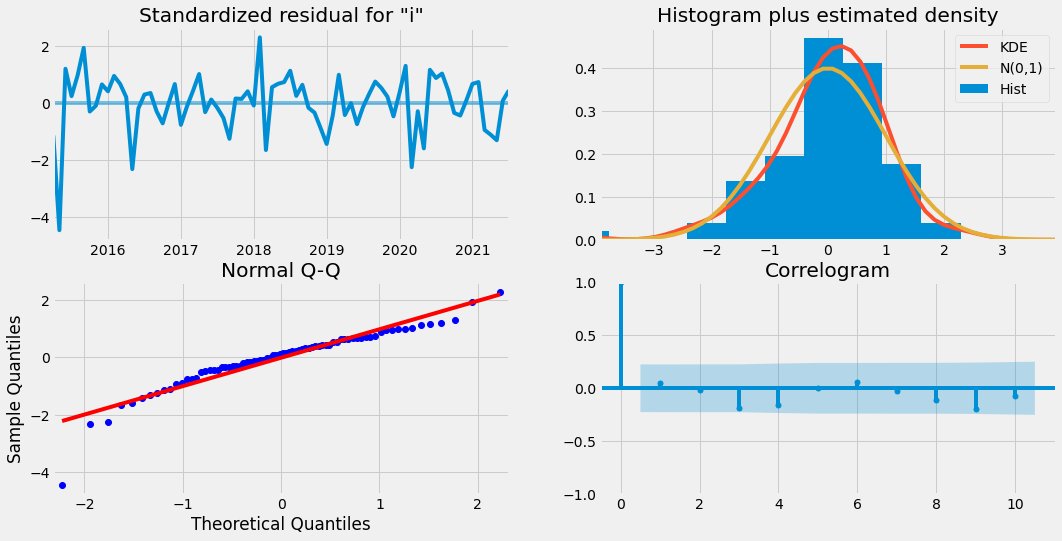

In [84]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

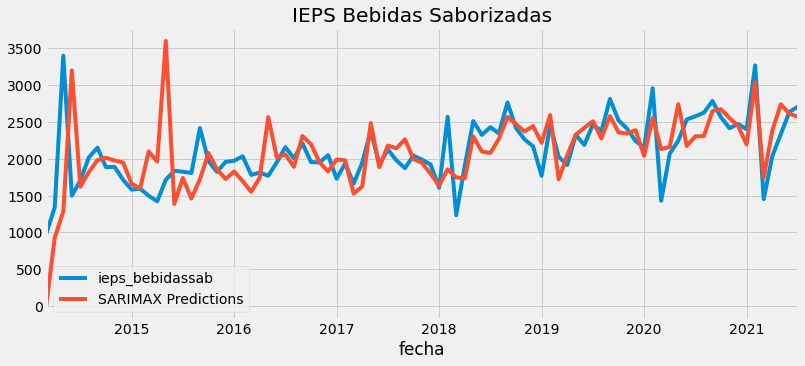

In [85]:
predictions = results.predict(start=0, end=len(ieps_bebidassab)-1, dynamic=False, typ='levels').rename('SARIMAX Predictions')
title = 'IEPS Bebidas Saborizadas'
ax = ieps_bebidassab.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [86]:
r2_score(ieps_bebidassab, predictions)
evaluation_results = pd.DataFrame({'r2_score': r2_score(ieps_bebidassab, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(ieps_bebidassab, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(ieps_bebidassab, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - ieps_bebidassab)/np.abs(ieps_bebidassab))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0  -0.14519           281.832344       208754.408681   

   mean_absolute_percentage_error  
0                       14.857657

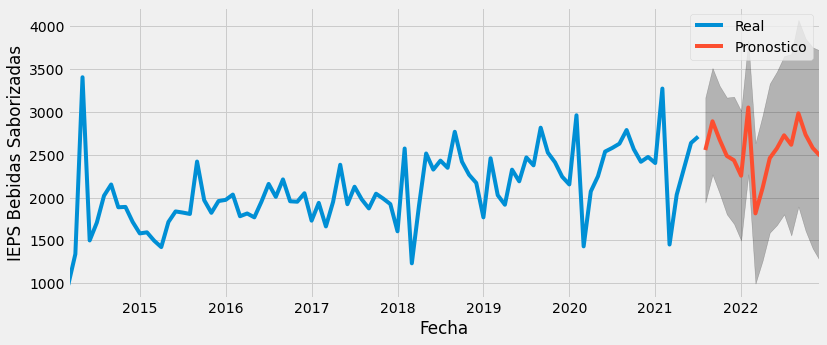

In [87]:
pred_f = results.get_forecast(steps=17)
pred_ci = pred_f.conf_int()
ax = ieps_bebidassab.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IEPS Bebidas Saborizadas')
plt.legend()
plt.show()

In [88]:
x=pred_f.predicted_mean
x.to_csv('arima_iepsbebidassab.csv')

### 4.6 IEPS Alimentos

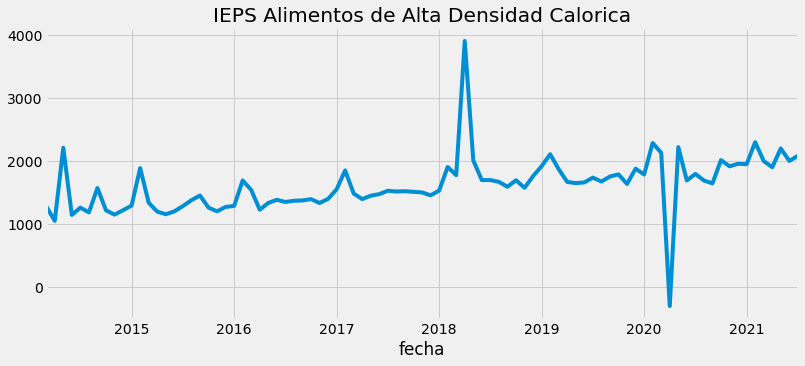

In [89]:
ieps_alimentosp=df['ieps_alimentos']
ieps_alimentos=ieps_alimentosp.dropna()
ieps_alimentos.plot(figsize=(12,5))
plt.title('IEPS Alimentos de Alta Densidad Calorica')
plt.show()

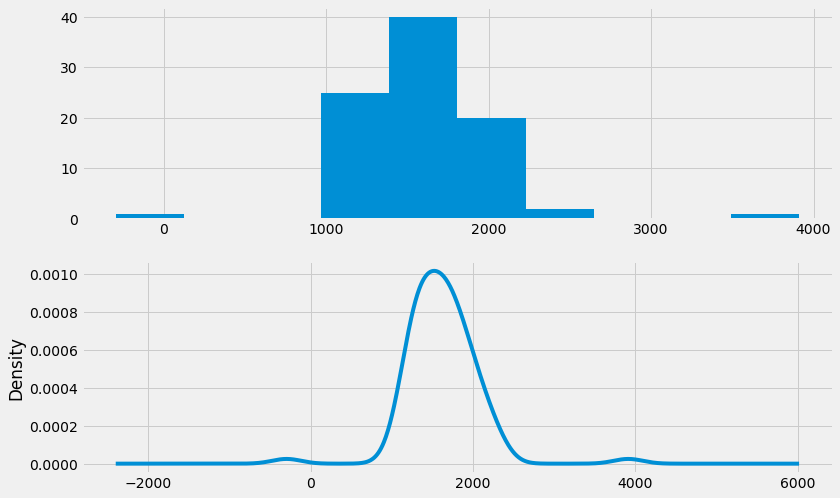

In [90]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,8))
ieps_alimentos.hist(ax=ax1)
ieps_alimentos.plot(kind='kde',ax=ax2)
plt.show()

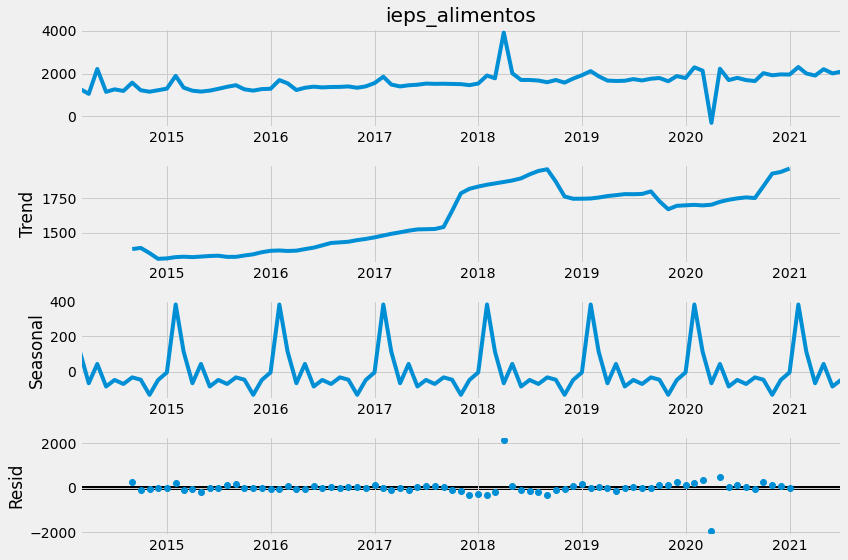

In [91]:
decomposition = seasonal_decompose(ieps_alimentos, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show();

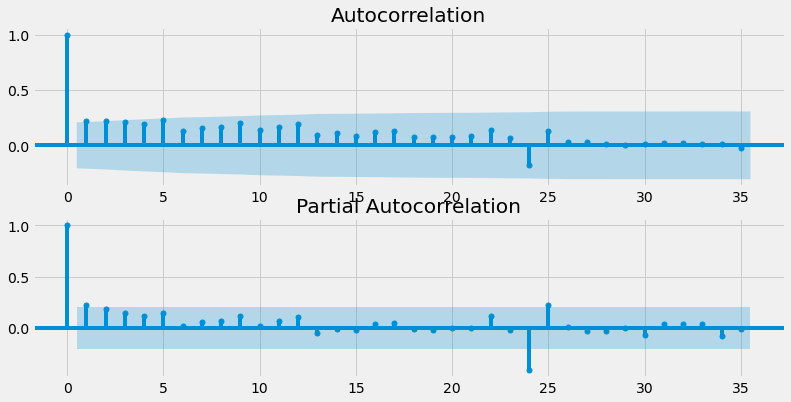

In [92]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(ieps_alimentos, lags=35, ax=ax1)
ax2 = plot_pacf(ieps_alimentos, lags=35, ax=ax2)
plt.show()

In [93]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ieps_alimentos)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -4.737662
p-value                         0.000071
#Lags Used                      1.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


In [94]:
df_diff = ieps_alimentos.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2021-03-01    -143.8
2021-04-01    2334.2
2021-05-01   -2225.1
2021-06-01     332.4
2021-07-01     -23.3
Name: ieps_alimentos, dtype: float64

In [95]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.242012e+00
p-value                        1.873679e-10
#Lags Used                     3.000000e+00
Number of Observations Used    7.200000e+01
Critical Value (1%)           -3.524624e+00
Critical Value (5%)           -2.902607e+00
Critical Value (10%)          -2.588679e+00
dtype: float64


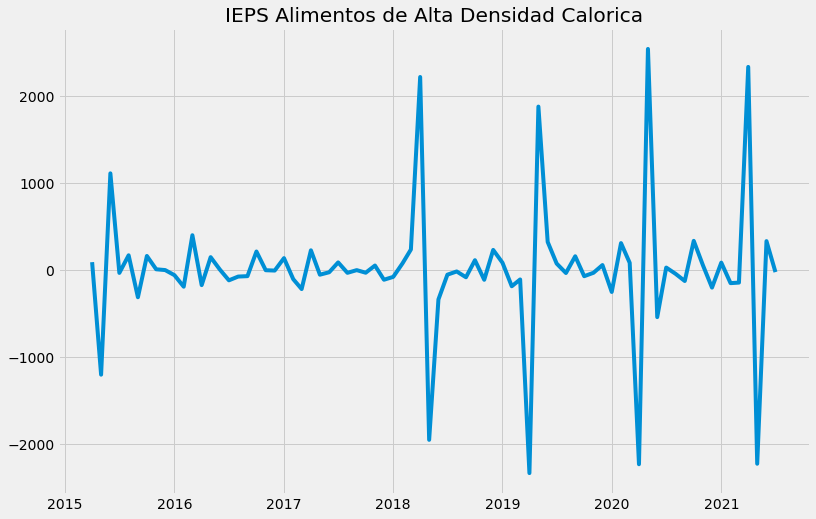

In [96]:
plt.plot(df_diff)
plt.title('IEPS Alimentos de Alta Densidad Calorica')
#plt.savefig('diffplot')
plt.show()

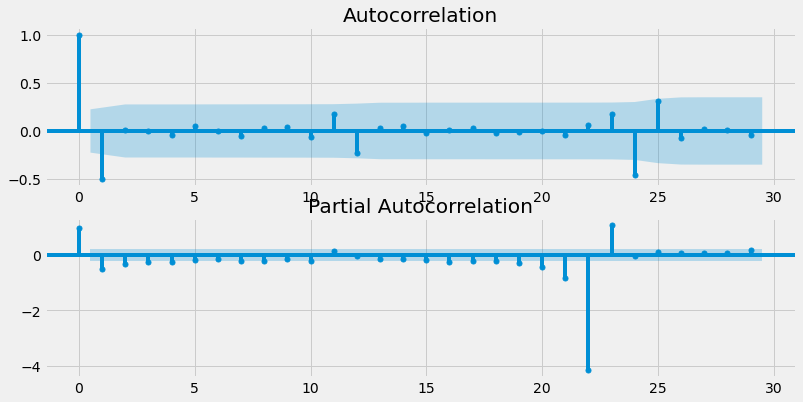

In [97]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=29, ax=ax1)
ax2 = plot_pacf(df_diff, lags=29, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [98]:
model = pm.auto_arima(ieps_alimentos, seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=12, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1339.390, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1337.207, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1332.400, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1339.390, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1338.045, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1338.497, Time=0.45 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1326.810, Time=3.41 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=1333.432, Time=0.61 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1331.319, Time=3.10 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=i

In [99]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   89
Model:             SARIMAX(0, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -657.405
Date:                                 Tue, 07 Sep 2021   AIC                           1326.810
Time:                                         16:00:56   BIC                           1341.742
Sample:                                              0   HQIC                          1332.829
                                                  - 89                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1620.4010    901.203      1.798      0.072    -145.925    3386.727
ma.L1          0.2268      0.135      1.676      0.094      -0.038       0.492
ar.S.L12       0.0056      0.550      0.010      0.992      -1.073       1.084
ma.S.L12       0.3717      0.714      0.521      0.602      -1.027       1.770
ma.S.L24      -0.4066      0.250     -1.628      0.103      -0.896       0.083
sigma2      1.477e+05   2.64e+04      5.596      0.000     9.6e+04    1.99e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               499.58
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                             2.21
Prob(H) (two-sided):                  0.18   Kurtosis:                        13.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
model = SARIMAX(ieps_alimentos,order=(0,0,1),seasonal_order=(1,0,2,12))
results = model.fit()
results.summary()

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                          ieps_alimentos   No. Observations:                   89
Model:             SARIMAX(0, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -687.432
Date:                                 Tue, 07 Sep 2021   AIC                           1384.863
Time:                                         16:03:10   BIC                           1397.306
Sample:                                     03-01-2014   HQIC                          1389.879
                                          - 07-01-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2552      0.113      2.257      0.024       0.034       0.477
ar.S.L12       0.9984      0.003    391.359      0.000       0.993       1.003
ma.S.L12      -0.2519      0.073     -3.467      0.001      -0.394      -0.110
ma.S.L24      -0.5880      0.071     -8.301      0.000      -0.727      -0.449
sigma2      1.925e+05   5.13e-07   3.75e+11      0.000    1.92e+05    1.92e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.68   Jarque-Bera (JB):               687.86
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                             0.54
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.61e+26. Standard errors may be unstable.
"""

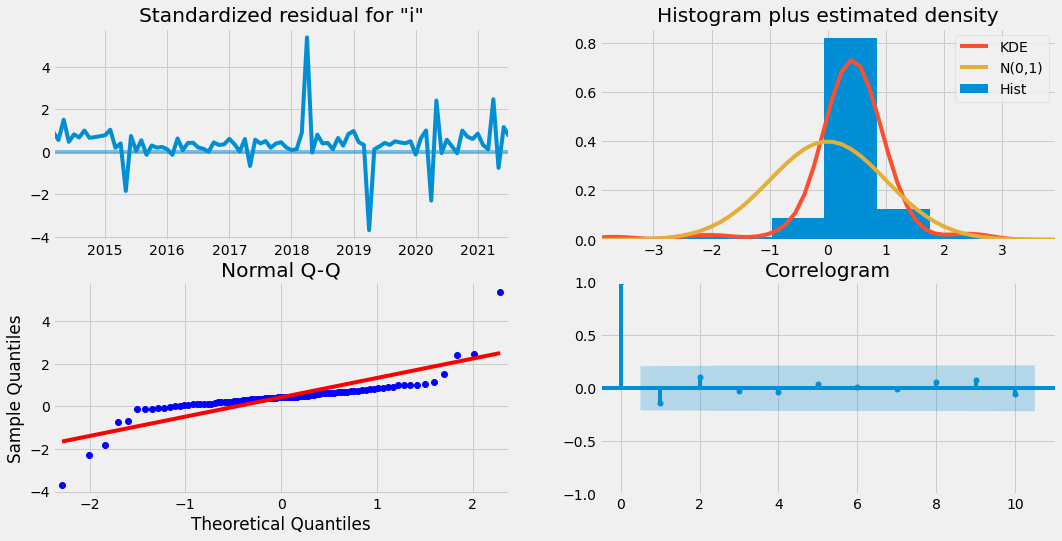

In [101]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

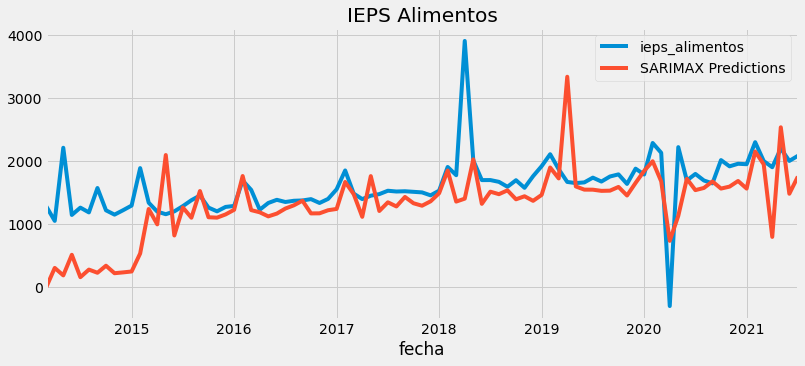

In [102]:
predictions = results.predict(start=0, end=len(ieps_alimentos)-1, dynamic=False, typ='levels').rename('SARIMAX Predictions')
title = 'IEPS Alimentos'
ax = ieps_alimentos.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [103]:
r2_score(ieps_alimentos, predictions)
evaluation_results = pd.DataFrame({'r2_score': r2_score(ieps_alimentos, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(ieps_alimentos, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(ieps_alimentos, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - ieps_alimentos)/np.abs(ieps_alimentos))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0 -0.950254           398.210379       374916.801389   

   mean_absolute_percentage_error  
0                       27.921206

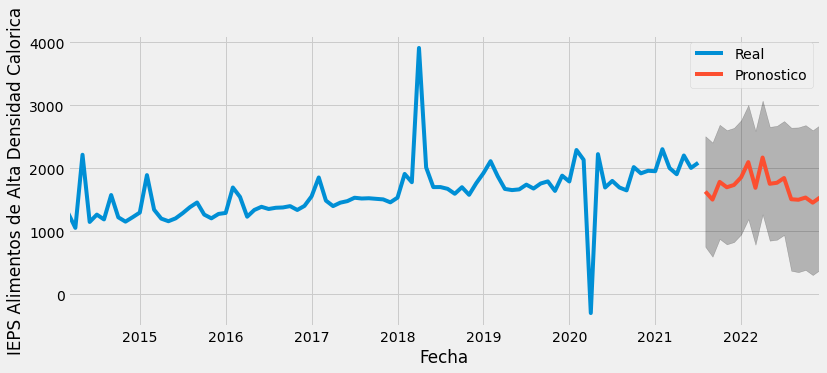

In [104]:
pred_f = results.get_forecast(steps=17)
pred_ci = pred_f.conf_int()
ax = ieps_alimentos.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IEPS Alimentos de Alta Densidad Calorica')
plt.legend()
plt.show()

In [105]:
x=pred_f.predicted_mean
x.to_csv('arima_iepsalimentos.csv')

### 4.7 Impuesto a la Importación

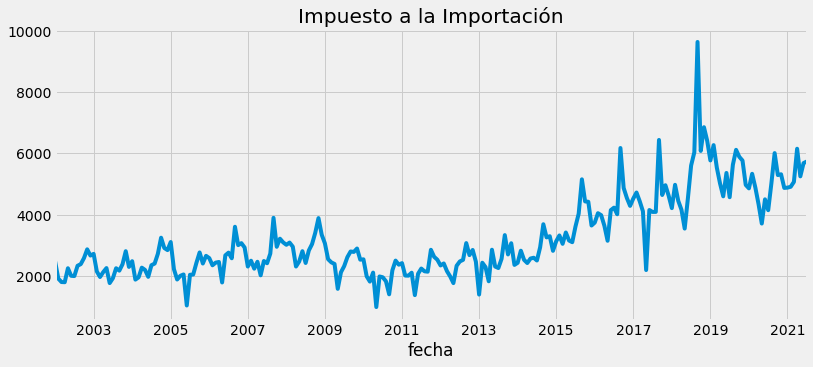

In [106]:
importacionp=df['importacion']
importacion=importacionp.dropna()
importacion.plot(figsize=(12,5))
plt.title('Impuesto a la Importación')
plt.show()

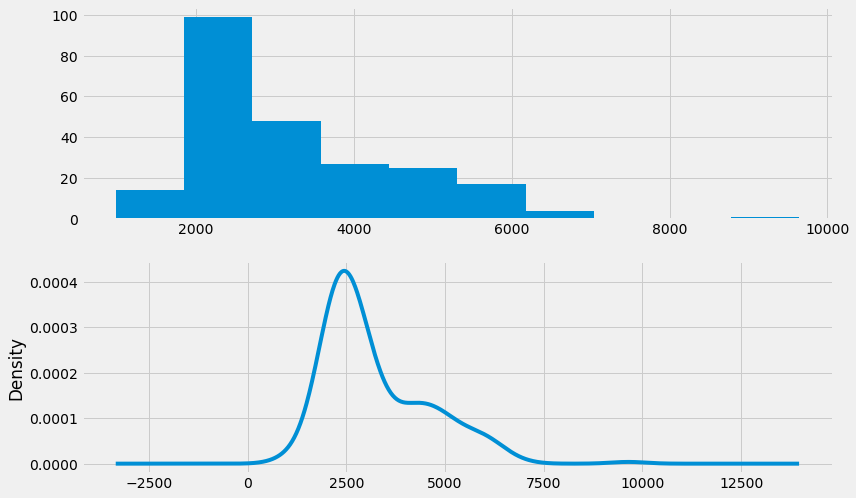

In [107]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,8))
importacion.hist(ax=ax1)
importacion.plot(kind='kde',ax=ax2)
plt.show()

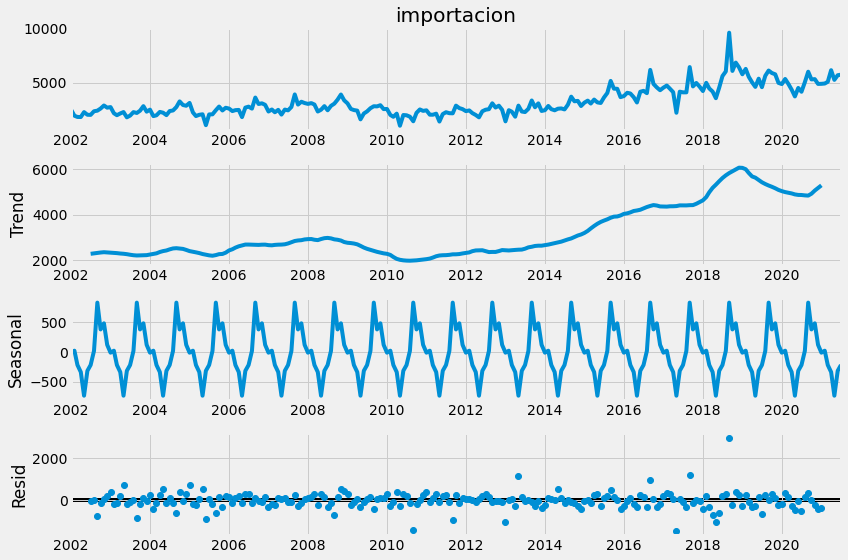

In [108]:
decomposition = seasonal_decompose(importacion, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show();

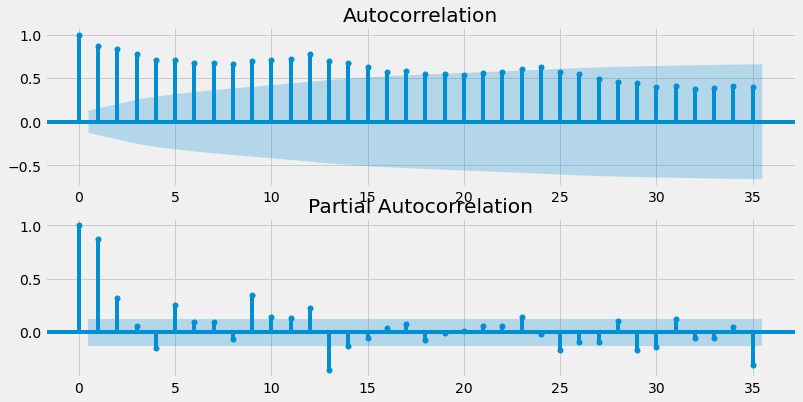

In [109]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(importacion, lags=35, ax=ax1)
ax2 = plot_pacf(importacion, lags=35, ax=ax2)
plt.show()

In [110]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(importacion)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.214093
p-value                          0.936821
#Lags Used                      13.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


In [111]:
df_diff = importacion.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2021-03-01     610.3
2021-04-01    1625.0
2021-05-01    -271.0
2021-06-01    -359.5
2021-07-01     408.7
Name: importacion, dtype: float64

In [112]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -5.421195
p-value                          0.000003
#Lags Used                      15.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64


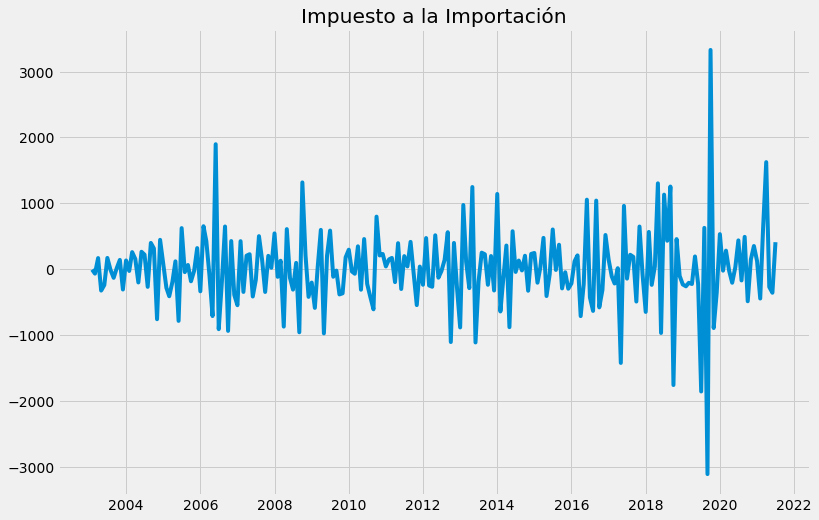

In [113]:
plt.plot(df_diff)
plt.title('Impuesto a la Importación')
#plt.savefig('diffplot')
plt.show()

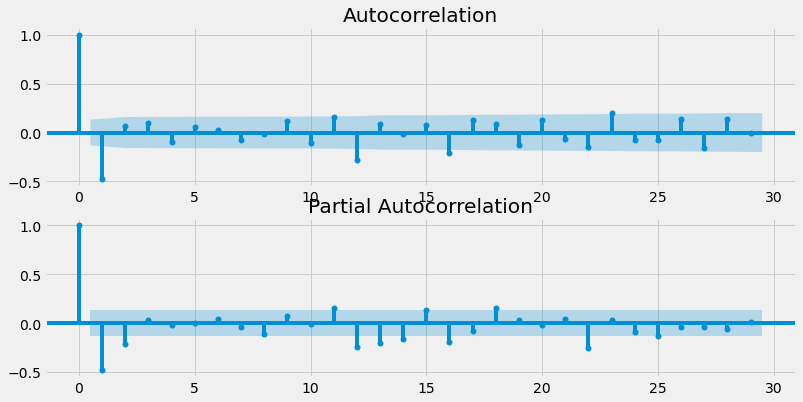

In [114]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=29, ax=ax1)
ax2 = plot_pacf(df_diff, lags=29, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [115]:
model = pm.auto_arima(importacion, seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=12, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3612.888, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3700.765, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3562.432, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3596.841, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3700.765, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3665.381, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3559.954, Time=0.65 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3560.535, Time=3.77 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3559.841, Time=0.53 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3599.494, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3561.581, Time=1.52 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3574.597, Time=0.60 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3550.137, Time=1.15 sec
 ARIMA(2,1,0)(0,0,1)[12]

In [116]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  235
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1769.068
Date:                              Tue, 07 Sep 2021   AIC                           3550.137
Time:                                      16:04:08   BIC                           3570.869
Sample:                                           0   HQIC                          3558.496
                                              - 235                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.7005     20.720      0.323      0.746     -33.909      47.310
ar.L1         -0.5724      0.050    -11.530      0.000      -0.670      -0.475
ar.L2         -0.2278      0.063     -3.634      0.000      -0.351      -0.105
ar.S.L12       0.8175      0.078     10.461      0.000       0.664       0.971
ma.S.L12      -0.3359      0.139     -2.419      0.016      -0.608      -0.064
sigma2      2.088e+05   1.23e+04     16.912      0.000    1.85e+05    2.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               306.06
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               3.76   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
model = SARIMAX(importacion,order=(2,1,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          importacion   No. Observations:                  235
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1769.148
Date:                              Tue, 07 Sep 2021   AIC                           3548.296
Time:                                      16:04:10   BIC                           3565.572
Sample:                                  01-01-2002   HQIC                          3555.262
                                       - 07-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5718      0.049    -11.552      0.000      -0.669      -0.475
ar.L2         -0.2270      0.063     -3.609      0.000      -0.350      -0.104
ar.S.L12       0.8194      0.076     10.741      0.000       0.670       0.969
ma.S.L12      -0.3380      0.137     -2.462      0.014      -0.607      -0.069
sigma2      2.088e+05   1.23e+04     16.926      0.000    1.85e+05    2.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               303.51
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               3.76   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

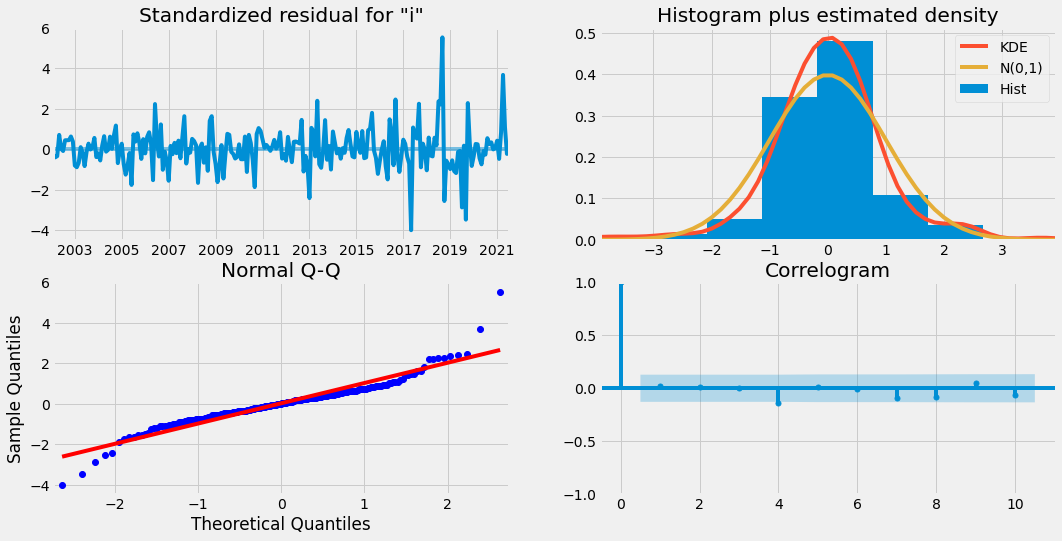

In [118]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

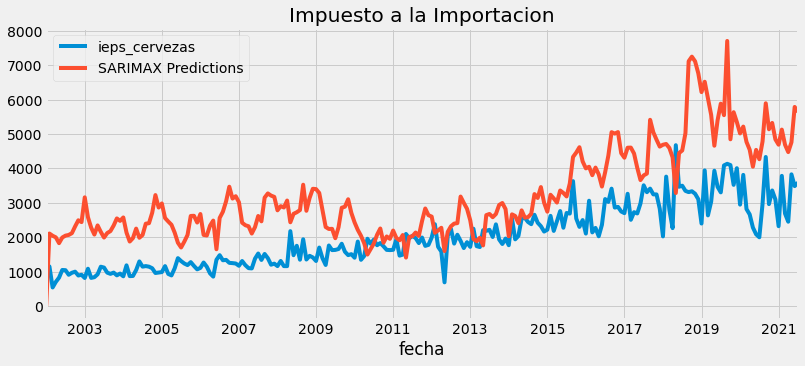

In [119]:
predictions = results.predict(start=0, end=len(importacion)-1, dynamic=False, typ='levels').rename('SARIMAX Predictions')
title = 'Impuesto a la Importacion'
ax = ieps_cervezas.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [120]:
r2_score(importacion, predictions)
evaluation_results = pd.DataFrame({'r2_score': r2_score(importacion, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(importacion, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(importacion, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - importacion)/np.abs(importacion))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0   0.86514           328.450036       236552.353704   

   mean_absolute_percentage_error  
0                       11.205572

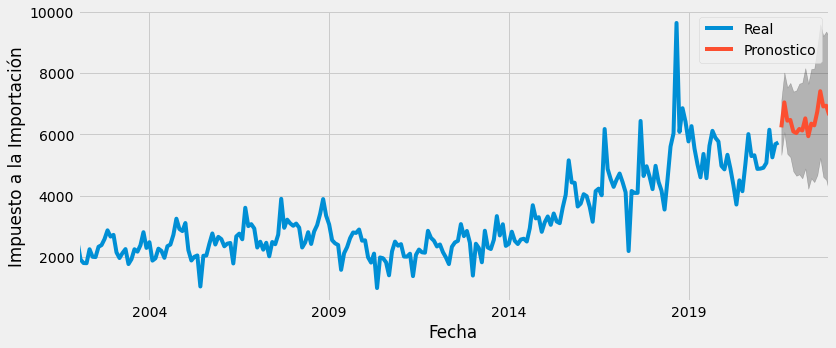

In [121]:
pred_f = results.get_forecast(steps=17)
pred_ci = pred_f.conf_int()
ax = importacion.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Impuesto a la Importación')
plt.legend()
plt.show()

In [122]:
x=pred_f.predicted_mean
x.to_csv('arima_importacion.csv')

### 4.8 Ingresos Petroleros / RFP Petroleros

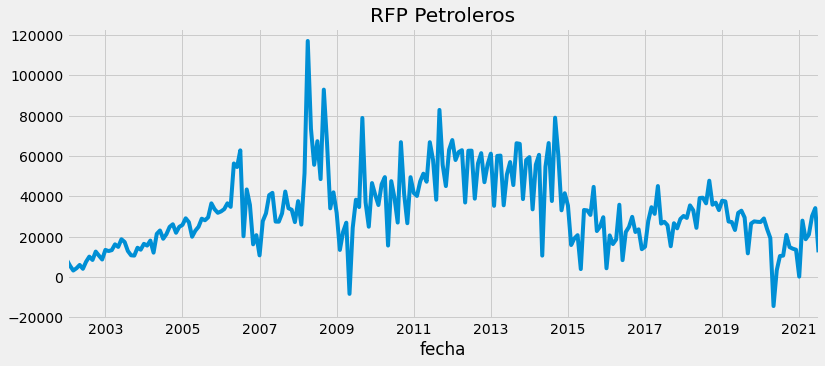

In [123]:
fmpedp=df['rfp_petroleros']
fmped=fmpedp.dropna()
fmped.plot(figsize=(12,5))
plt.title('RFP Petroleros')
plt.show()

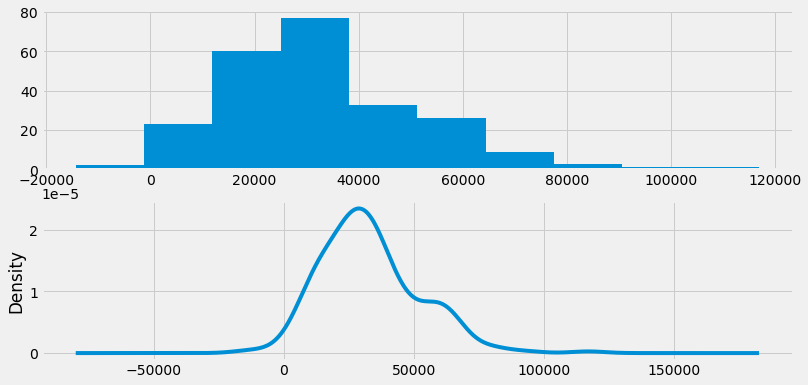

In [124]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,6))
fmped.hist(ax=ax1)
fmped.plot(kind='kde',ax=ax2)
plt.show()

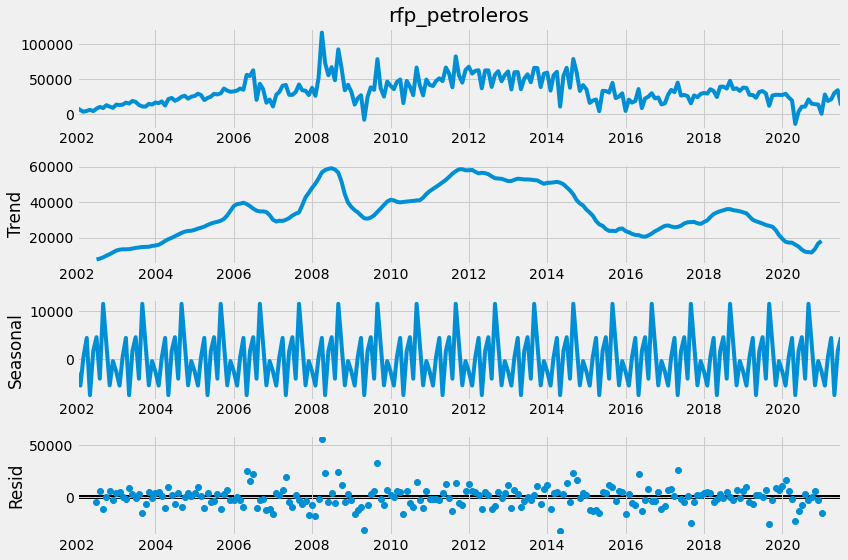

In [125]:
decomposition = seasonal_decompose(fmped, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show();

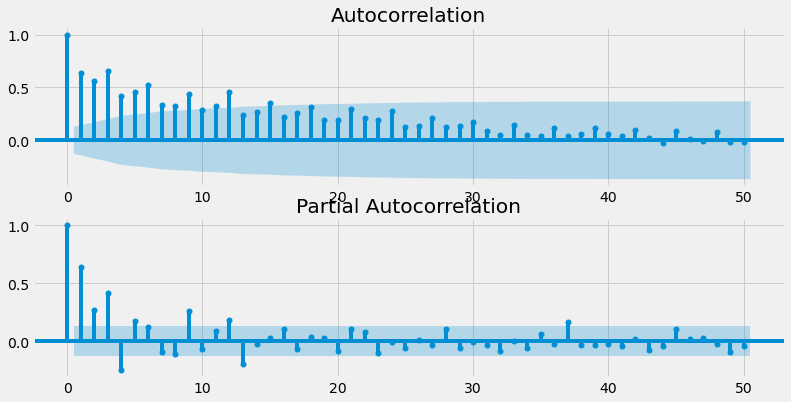

In [126]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(fmped, lags=50, ax=ax1)
ax2 = plot_pacf(fmped, lags=50, ax=ax2)
plt.show()

In [127]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(fmped)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.313334
p-value                          0.167703
#Lags Used                      12.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


In [128]:
df_diff = fmped.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2021-03-01    -3961.7
2021-04-01     6746.5
2021-05-01    42871.5
2021-06-01   -13774.2
2021-07-01   -28992.0
Name: rfp_petroleros, dtype: float64

In [129]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.450070e+00
p-value                        1.531296e-08
#Lags Used                     1.500000e+01
Number of Observations Used    2.060000e+02
Critical Value (1%)           -3.462499e+00
Critical Value (5%)           -2.875675e+00
Critical Value (10%)          -2.574304e+00
dtype: float64


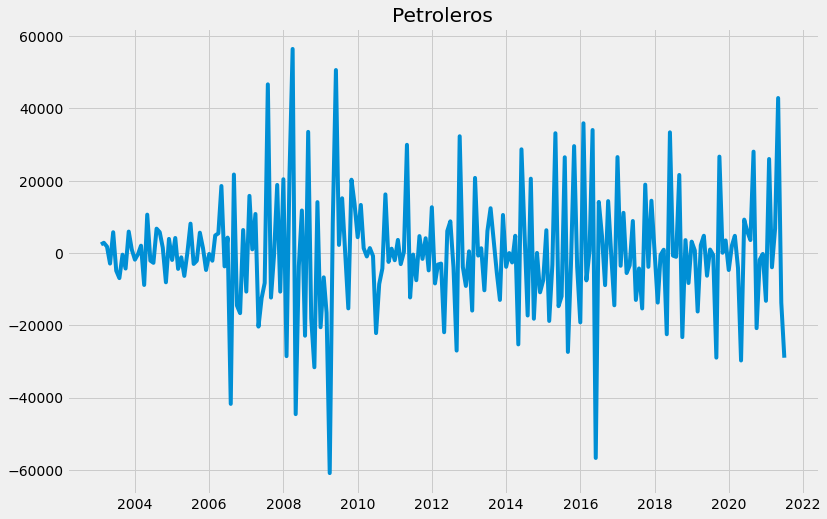

In [130]:
plt.plot(df_diff)
plt.title('Petroleros')
#plt.savefig('diffplot')
plt.show()

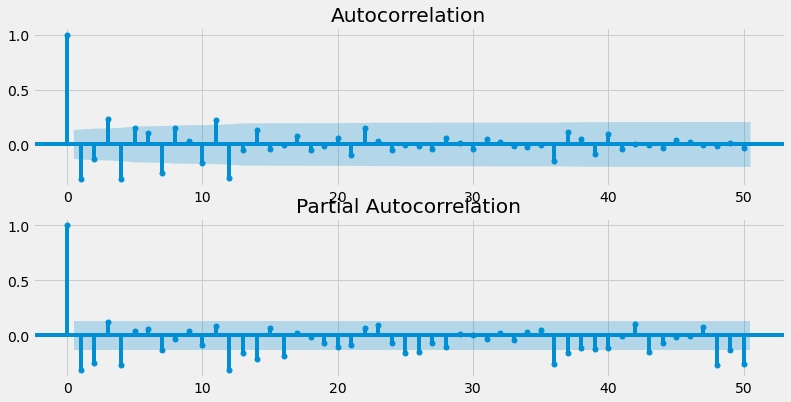

In [131]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [132]:
model = pm.auto_arima(fmped, seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=12, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=5145.224, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5198.201, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5113.945, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5106.730, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5198.201, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5121.635, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5100.094, Time=0.22 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5099.945, Time=0.12 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=5100.256, Time=0.28 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=5101.707, Time=0.54 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=5145.131, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=5100.114, Time=0.22 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=5102.162, Time=0.16 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=5084.363, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0

In [133]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  235
Model:             SARIMAX(5, 1, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -2513.061
Date:                                 Tue, 07 Sep 2021   AIC                           5050.122
Time:                                         16:06:37   BIC                           5091.586
Sample:                                              0   HQIC                          5066.840
                                                 - 235                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    127.3700    171.077      0.745      0.457    -207.936     462.676
ar.L1         -0.1777      0.137     -1.294      0.196      -0.447       0.091
ar.L2         -0.3967      0.107     -3.713      0.000      -0.606      -0.187
ar.L3          0.6573      0.097      6.801      0.000       0.468       0.847
ar.L4         -0.0225      0.111     -0.202      0.840      -0.241       0.196
ar.L5          0.1831      0.093      1.968      0.049       0.001       0.366
ma.L1         -0.2825      0.129     -2.193      0.028      -0.535      -0.030
ma.L2          0.1682      0.098      1.717      0.086      -0.024       0.360
ma.L3         -0.7564      0.086     -8.797      0.000      -0.925      -0.588
ma.S.L12       0.2417      0.076      3.169      0.002       0.092       0.391
ma.S.L24       0.1665      0.085      1.951      0.051      -0.001       0.334
sigma2      1.399e+08   1.33e-05   1.05e+13      0.000     1.4e+08     1.4e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               389.91
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.60
Prob(H) (two-sided):                  0.42   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.22e+29. Standard errors may be unstable.
"""

In [134]:
model = SARIMAX(fmped,order=(5,1,3),seasonal_order=(0,0,2,12))
results = model.fit()
results.summary()

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                          rfp_petroleros   No. Observations:                  235
Model:             SARIMAX(5, 1, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -2512.890
Date:                                 Tue, 07 Sep 2021   AIC                           5047.780
Time:                                         16:07:32   BIC                           5085.789
Sample:                                     01-01-2002   HQIC                          5063.106
                                          - 07-01-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1622      0.136     -1.188      0.235      -0.430       0.105
ar.L2         -0.3854      0.105     -3.685      0.000      -0.590      -0.180
ar.L3          0.6743      0.088      7.694      0.000       0.503       0.846
ar.L4         -0.0164      0.105     -0.157      0.876      -0.222       0.189
ar.L5          0.1924      0.090      2.130      0.033       0.015       0.369
ma.L1         -0.2958      0.126     -2.350      0.019      -0.543      -0.049
ma.L2          0.1642      0.098      1.671      0.095      -0.028       0.357
ma.L3         -0.7615      0.086     -8.877      0.000      -0.930      -0.593
ma.S.L12       0.2446      0.077      3.179      0.001       0.094       0.395
ma.S.L24       0.1700      0.083      2.039      0.041       0.007       0.334
sigma2      1.399e+08   4.98e-10   2.81e+17      0.000     1.4e+08     1.4e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               391.50
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.61
Prob(H) (two-sided):                  0.32   Kurtosis:                         9.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.03e+33. Standard errors may be unstable.
"""

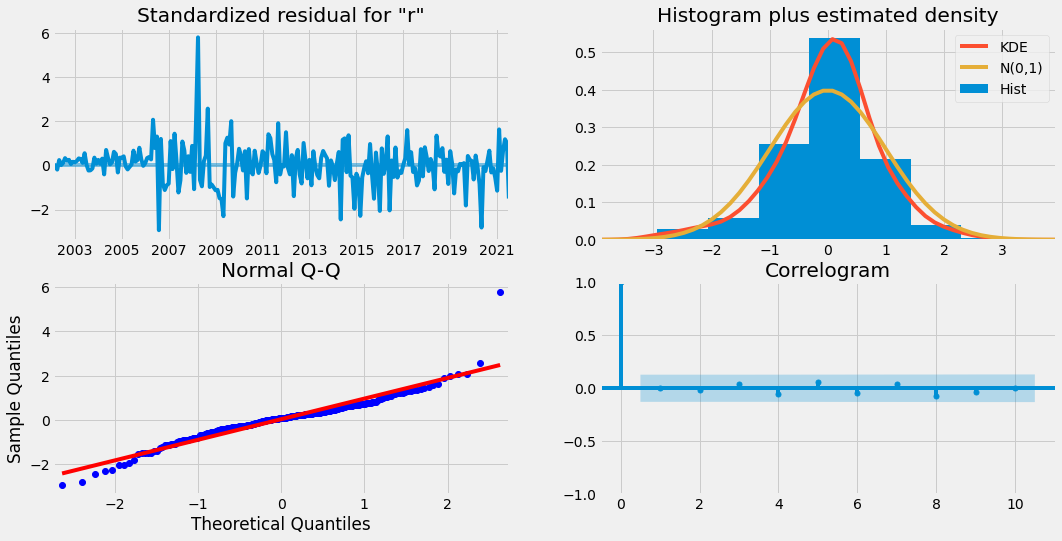

In [135]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

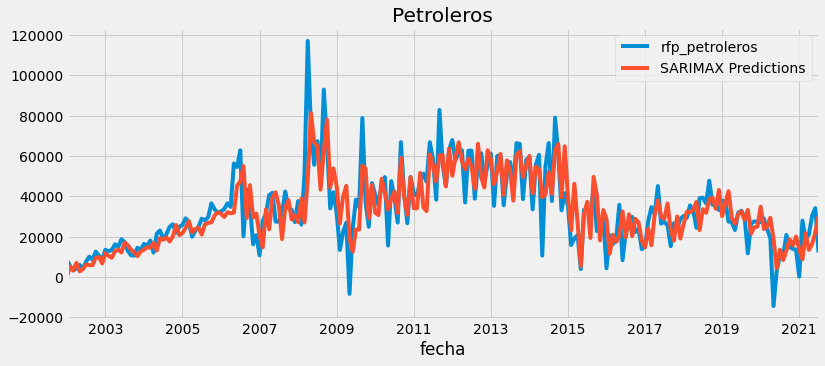

In [136]:
predictions = results.predict(start=0, end=len(fmped)-1, dynamic=False, typ='levels').rename('SARIMAX Predictions')
title = 'Petroleros'
ax = fmped.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [137]:
r2_score(fmped, predictions)
evaluation_results = pd.DataFrame({'r2_score': r2_score(fmped, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(fmped, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(fmped, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - fmped)/np.abs(fmped))*100 
evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0  0.656278          7761.555576        1.217827e+08   

   mean_absolute_percentage_error  
0                       58.638445

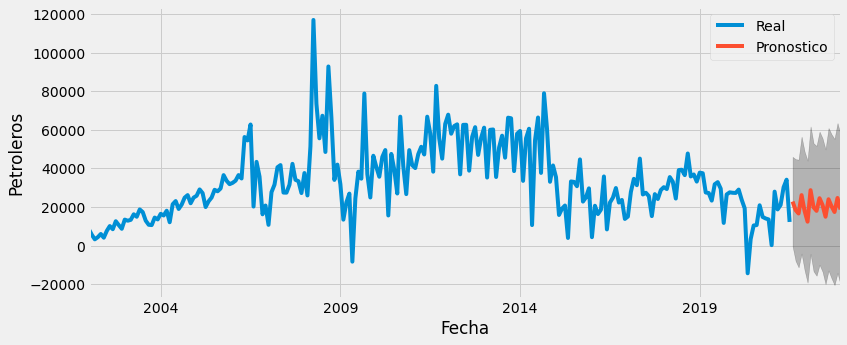

In [138]:
pred_f = results.get_forecast(steps=17)
pred_ci = pred_f.conf_int()
ax = fmped.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Petroleros')
plt.legend()
plt.show()

In [139]:
x=pred_f.predicted_mean
x.to_csv('arima_petroleros.csv')

## 5. Análisis de las Series Trimestrales

Como ya señalé antes, el Producto Interno Bruto (PIB) resulta ser una variable adecuada para estimar el Impuesto Sobre la Renta (ISR) y el Impuesto al Valor Agregado (IVA), además de otras variables como la reforma al ISR y la tasa misma del IVA, respectivamente. Así que me iré serie por serie, presentando los resultados de manera detallada solo la primer serie que es el ISR.

In [140]:
df = pd.read_csv('202108trimestrales.csv', sep=',', parse_dates=['fecha'], index_col='fecha', encoding = 'utf-8')
df['fecha']=df.index
df.tail()

ano  mes  dia       fechas  pib_real  pib_reale4     IPI  \
fecha                                                                   
2021-10-01  2021   10    1      2021/04  18725631  4681407.77  143.74   
2022-01-01  2022    1    1  2022/01 /r1  18021273  4505318.26  149.32   
2022-04-01  2022    4    1      2022/02  18331787  4582946.70  148.64   
2022-07-01  2022    7    1      2022/03  18308165  4577041.25  149.00   
2022-10-01  2022   10    1      2022/04  19118869  4779717.33  149.63   

            rfp_neta  isr  iva  rfp_real  isr_real  iva_real  tasa iva  \
fecha                                                                    
2021-10-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-01-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-04-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-07-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-10-01       NaN  NaN  NaN       NaN       NaN       NaN        16   

            reformaisr  covid      fecha  
fecha                                     
2021-10-01           1      0 2021-10-01  
2022-01-01           1      0 2022-01-01  
2022-04-01           1      0 2022-04-01  
2022-07-01           1      0 2022-07-01  
2022-10-01           1      0 2022-10-01

### 5.1 Impuesto Sobre la Renta, ISR

Una vez que tome en cuenta la serie en términos reales y el desfase de 2 meses que existe en la serie del ISR, la serie mantuvo un crecimiento en términos reales hasta 2017-2018, y a partir de entonces mantiene un compartamiento un poco más vólatil:

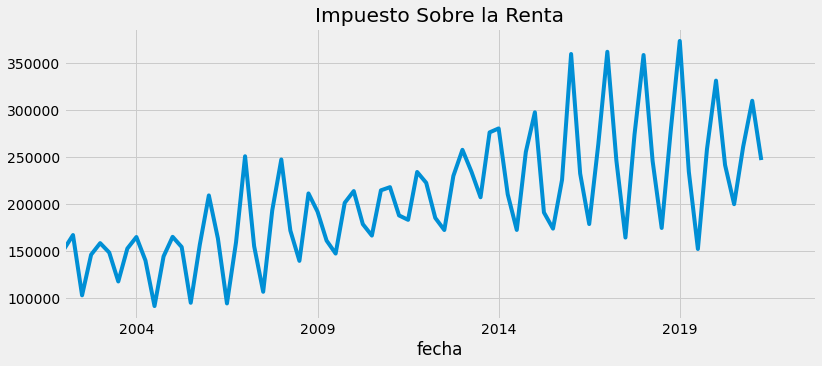

In [141]:
isrp=df['isr_real']
#isr=isrp.dropna()
isrp.plot(figsize=(12,5))
plt.title('Impuesto Sobre la Renta')
plt.show()
#isr.head()

Su histograma y función de densidad se ven como sigue:

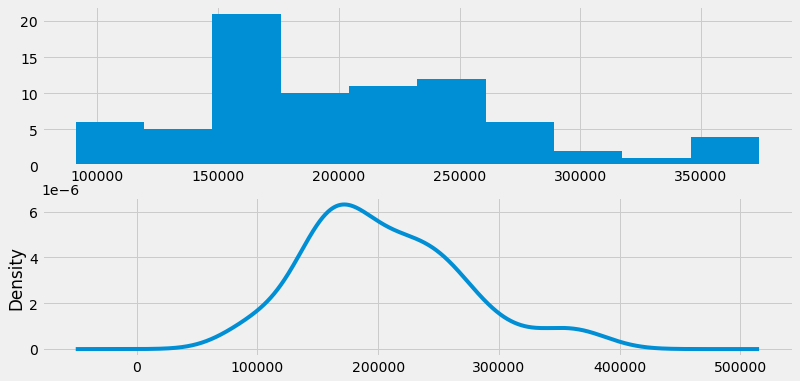

In [142]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,6))
isrp.hist(ax=ax1)
isrp.plot(kind='kde',ax=ax2)
plt.show()

La descomposición de la serie del ISR se ve como sigue:

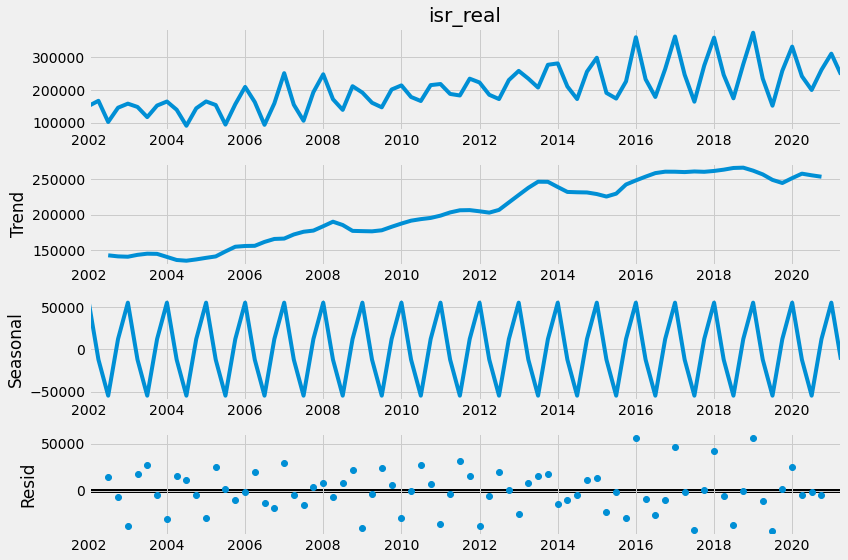

In [143]:
decomposition = seasonal_decompose(isrp.dropna(), freq=4, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show()

Y debido a que la serie es trimestral, los correlogramas no corren adecuadamente:

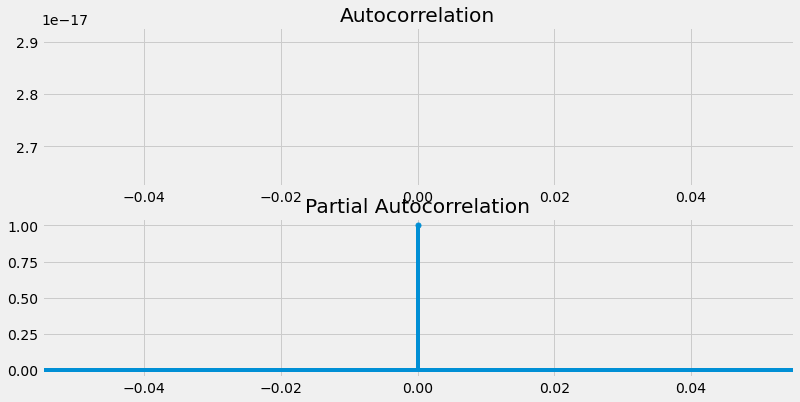

In [144]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(isrp, lags=40, ax=ax1)
ax2 = plot_pacf(isrp, lags=40, ax=ax2)
plt.show()

Aplico la prueba Dickey-Fuller a la serie en niveles y parece indicar que la serie tiene raíz unitaria. Sin embargo, al sacar diferencias, la serie sí parece ser estacionaria:

In [145]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(isrp.dropna())

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -0.848330
p-value                         0.804512
#Lags Used                      3.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


In [146]:
df_diff = isrp.diff().diff(4)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2020-04-01    49599.3000
2020-07-01    40612.2000
2020-10-01   -44964.9000
2021-01-01   -24391.2000
2021-04-01    26820.4148
Name: isr_real, dtype: float64

In [147]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -5.452966
p-value                         0.000003
#Lags Used                      7.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


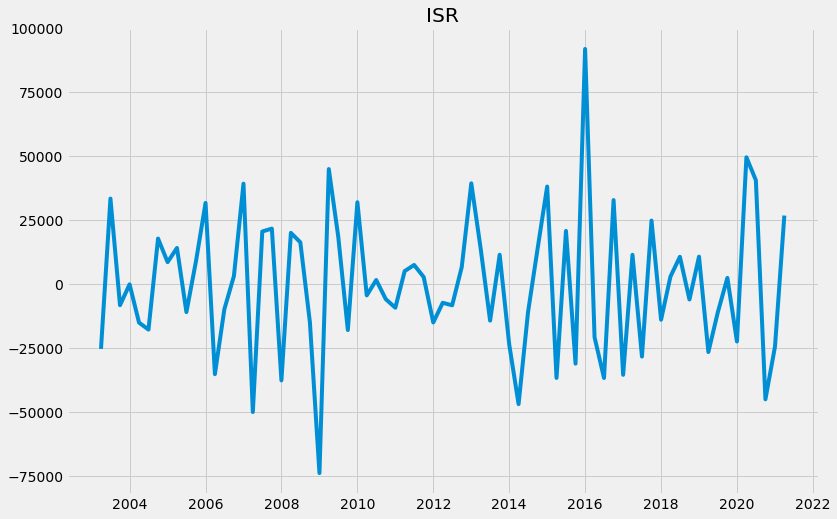

In [148]:
plt.plot(df_diff)
plt.title('ISR')
#plt.savefig('diffplot')
plt.show()

Los correlogramas de la serie en diferencias (aunque generan error)

Creo los objetos con las variables explicativas:

In [149]:
pib1=df[['reformaisr','pib_reale4']]
pib1.drop(pib1.tail(6).index,inplace=True)
pib1.shape

(78, 2)

In [150]:
pib1x=df[['reformaisr','pib_reale4']]
pib1x.drop(pib1x.head(78).index,inplace=True)
pib1x.shape

(6, 2)

Corro la función **auto_arima** inclyendo variables explicativas, y estos son los resultados que me arroja:

In [151]:
model = pm.auto_arima(isrp.dropna(), 
                      exogenous=pib1,
                      d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=12, test='adf', stepwise=True, trace=True)                     

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1575.307, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1577.579, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1576.695, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1548.858, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1551.161, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1550.083, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1547.356, Time=0.92 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1548.003, Time=0.87 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1569.656, Time=0.49 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1547.262, Time=0.96 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1549.452, Time=0.49 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1547.512, Time=1.83 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1550.502, Time=0.67 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1568.056, Time=0.51 sec
 ARIMA(2,1,1)(0,1,2

In [152]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   78
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -744.623
Date:                            Tue, 07 Sep 2021   AIC                           1507.245
Time:                                    16:10:38   BIC                           1526.815
Sample:                                01-01-2002   HQIC                          1514.967
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -132.9532   2976.550     -0.045      0.964   -5966.885    5700.978
reformaisr -4.675e+04   1.67e+04     -2.798      0.005   -7.95e+04    -1.4e+04
pib_reale4     0.0367      0.015      2.435      0.015       0.007       0.066
ar.L1         -0.8685      0.236     -3.682      0.000      -1.331      -0.406
ar.L2         -0.9339      0.136     -6.866      0.000      -1.201      -0.667
ar.L3         -0.7855      0.224     -3.512      0.000      -1.224      -0.347
ma.L1          0.3145      0.336      0.936      0.350      -0.344       0.973
ma.S.L12      -0.7326      0.394     -1.862      0.063      -1.504       0.039
sigma2      7.069e+08      0.260   2.72e+09      0.000    7.07e+08    7.07e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 4.09
Prob(Q):                              0.74   Prob(JB):                         0.13
Heteroskedasticity (H):               1.31   Skew:                             0.57
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.96e+24. Standard errors may be unstable.
"""

In [153]:
#divide into train and validation set
isr=isrp.dropna()
isr.shape

(78,)

In [154]:
model = SARIMAX(isr,order=(3,1,1),seasonal_order=(0,1,1,12),exog=pib1)
results = model.fit()
results.summary()

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           isr_real   No. Observations:                   78
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -744.651
Date:                            Tue, 07 Sep 2021   AIC                           1505.303
Time:                                    16:11:01   BIC                           1522.698
Sample:                                01-01-2002   HQIC                          1512.166
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
reformaisr -4.675e+04   1.68e+04     -2.785      0.005   -7.97e+04   -1.38e+04
pib_reale4     0.0377      0.012      3.031      0.002       0.013       0.062
ar.L1         -0.8732      0.229     -3.815      0.000      -1.322      -0.425
ar.L2         -0.9434      0.134     -7.049      0.000      -1.206      -0.681
ar.L3         -0.7964      0.221     -3.610      0.000      -1.229      -0.364
ma.L1          0.3306      0.328      1.009      0.313      -0.312       0.973
ma.S.L12      -0.7445      0.378     -1.971      0.049      -1.485      -0.004
sigma2      7.071e+08      0.262    2.7e+09      0.000    7.07e+08    7.07e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 4.02
Prob(Q):                              0.67   Prob(JB):                         0.13
Heteroskedasticity (H):               1.32   Skew:                             0.56
Prob(H) (two-sided):                  0.52   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  2e+27. Standard errors may be unstable.
"""

Los residuales del modelo se comportan adecuadamente:

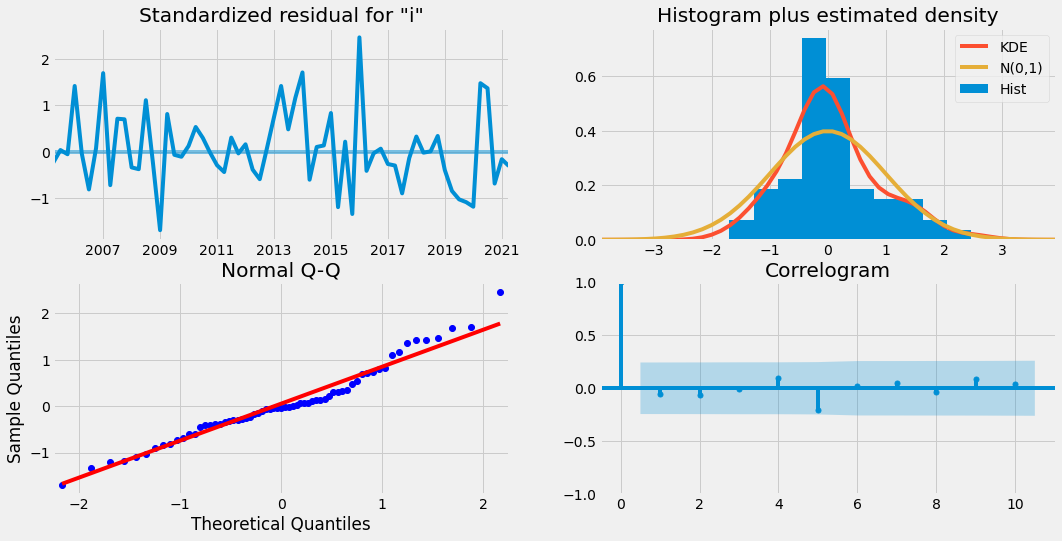

In [155]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

Y el pronóstico en sí, también se ve bastante prometedor.

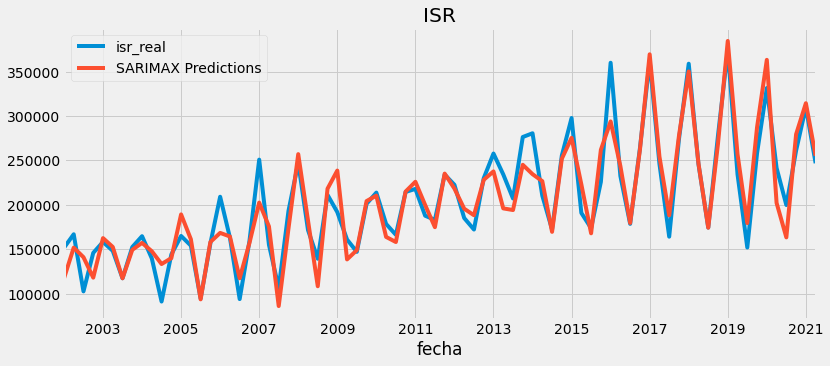

In [156]:
predictions = results.predict(start=0, end=len(isr)-1, dynamic=False, typ='levels', exog=pib1).rename('SARIMAX Predictions')
title = 'ISR'
ax = isr.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

Calculo los estadísticos del modelo:

In [157]:
r2_score(isr, predictions)
evaluation_results = pd.DataFrame({'r2_score': r2_score(isr, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(isr, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(isr, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - isr)/np.abs(isr))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0  0.882369         16147.726329        4.767937e+08   

   mean_absolute_percentage_error  
0                        8.620649

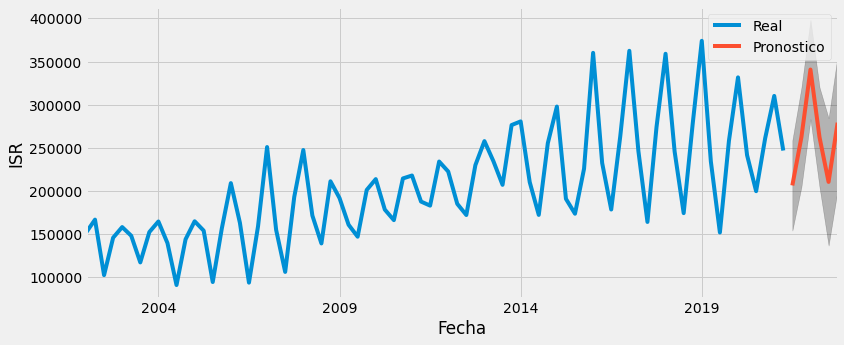

In [158]:
pred_f = results.get_forecast(steps=6, exog=pib1x)
pred_ci = pred_f.conf_int()
ax = isr.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('ISR')
plt.legend()
plt.show()

In [159]:
x=pred_f.predicted_mean
x.to_csv('arima_isr.csv')

### 5.2 Impuesto al Valor Agregado, IVA

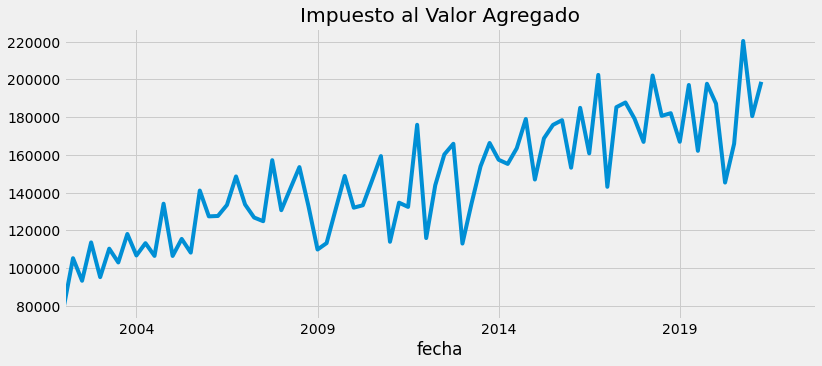

In [160]:
ivap=df['iva_real']
#iva=ivap.dropna()
ivap.plot(figsize=(12,5))
plt.title('Impuesto al Valor Agregado')
plt.show()

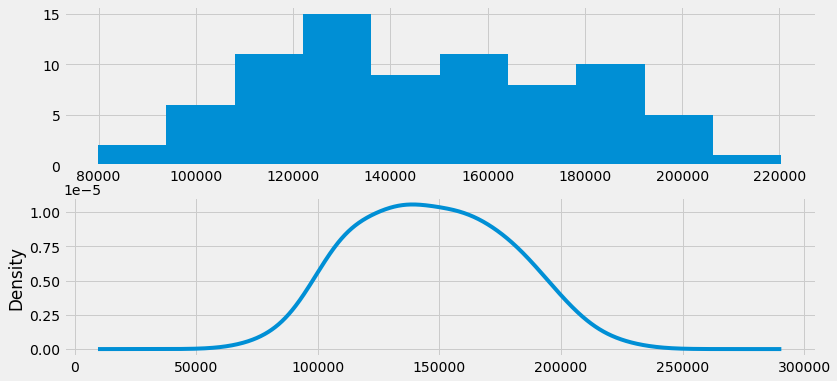

In [161]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,6))
ivap.hist(ax=ax1)
ivap.plot(kind='kde',ax=ax2)
plt.show()

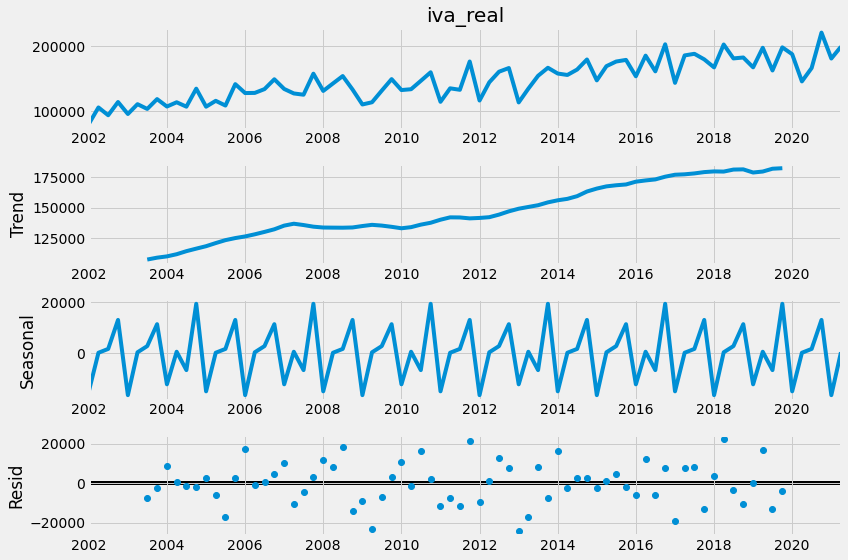

In [162]:
decomposition = seasonal_decompose(ivap.dropna(), freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show()

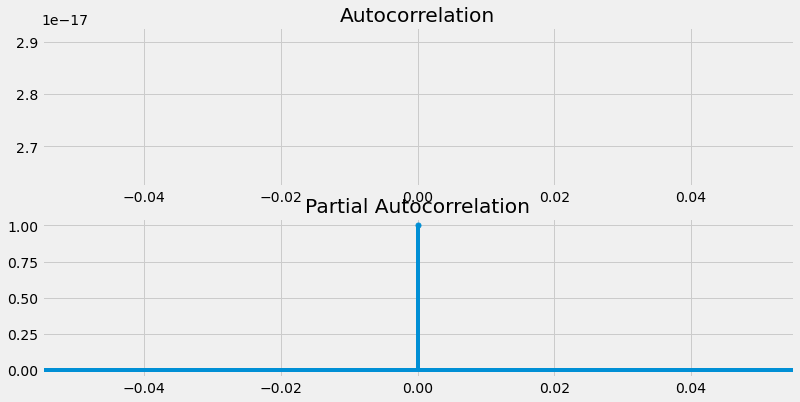

In [163]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(ivap, lags=40, ax=ax1)
ax2 = plot_pacf(ivap, lags=40, ax=ax2)
plt.show()

In [164]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ivap.dropna())

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -0.921863
p-value                         0.780687
#Lags Used                      7.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [165]:
df_diff = ivap.diff().diff(4)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2020-04-01   -71931.700
2020-07-01    55483.700
2020-10-01    18915.500
2021-01-01   -29311.300
2021-04-01    60015.752
Name: iva_real, dtype: float64

In [166]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.694337e+00
p-value                        1.392193e-11
#Lags Used                     5.000000e+00
Number of Observations Used    6.700000e+01
Critical Value (1%)           -3.531955e+00
Critical Value (5%)           -2.905755e+00
Critical Value (10%)          -2.590357e+00
dtype: float64


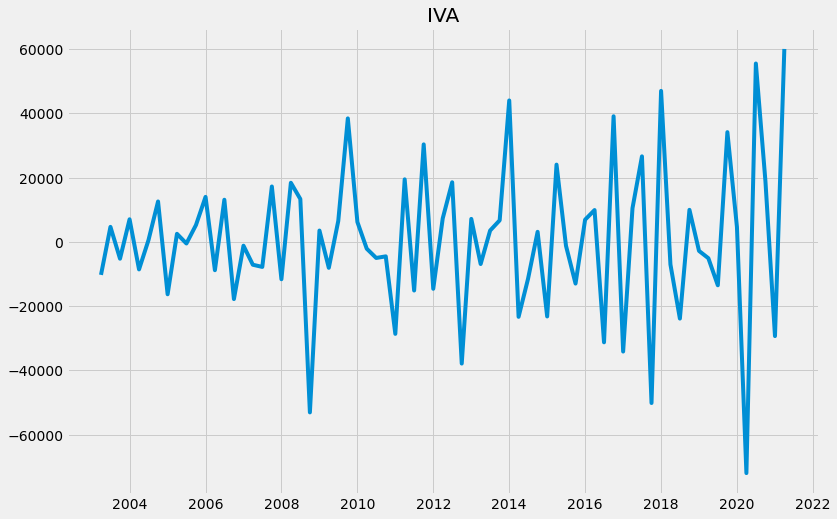

In [167]:
plt.plot(df_diff)
plt.title('IVA')
#plt.savefig('diffplot')
plt.show()

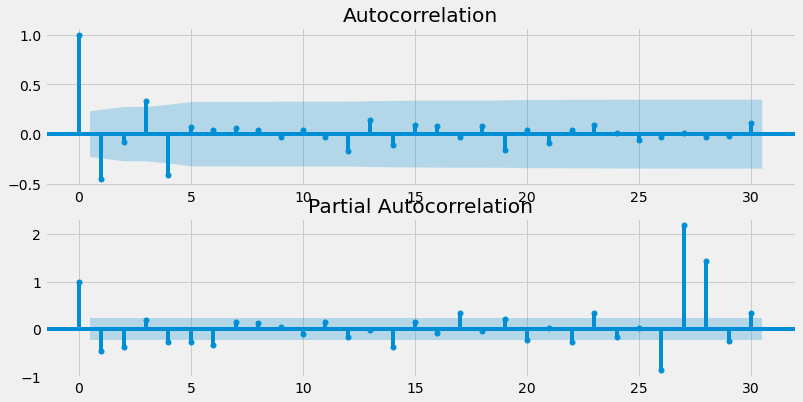

In [168]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=30, ax=ax1)
ax2 = plot_pacf(df_diff, lags=30, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [169]:
pib2=df[['tasa iva','pib_reale4']]
pib2.drop(pib2.tail(6).index,inplace=True)
pib2.shape

(78, 2)

In [170]:
pib2x=df[['tasa iva','pib_reale4']]
pib2x.drop(pib2x.head(78).index,inplace=True)
pib2x.shape

(6, 2)

In [171]:
model = pm.auto_arima(ivap.dropna(), 
                      exogenous=pib2,
                      d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)                     

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1492.418, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1500.567, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1491.748, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1475.870, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1499.456, Time=0.21 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1477.637, Time=0.69 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1477.867, Time=1.61 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1484.833, Time=0.40 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.47 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1490.548, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1477.615, Time=0.56 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1477.711, Time=0.54 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1482.501, Time=0.32 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1477.259, Time=0.88 sec
 ARIMA(0,1,1)(0,1,1)[12]

In [172]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   78
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -731.935
Date:                            Tue, 07 Sep 2021   AIC                           1475.870
Time:                                    16:12:15   BIC                           1488.916
Sample:                                01-01-2002   HQIC                          1481.018
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1127.9484    532.133      2.120      0.034      84.987    2170.910
tasa iva    1.433e+04   2590.666      5.532      0.000    9254.426    1.94e+04
pib_reale4    -0.0056      0.009     -0.624      0.533      -0.023       0.012
ma.L1         -0.5297      0.118     -4.478      0.000      -0.761      -0.298
ma.S.L12      -0.7806      0.252     -3.095      0.002      -1.275      -0.286
sigma2      3.211e+08      0.058   5.58e+09      0.000    3.21e+08    3.21e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 2.02
Prob(Q):                              0.66   Prob(JB):                         0.36
Heteroskedasticity (H):               1.67   Skew:                            -0.41
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.75e+24. Standard errors may be unstable.
"""

In [173]:
#divide into train and validation set
iva=ivap.dropna()
iva.shape

(78,)

In [174]:
model = SARIMAX(iva,order=(0,1,1),seasonal_order=(0,1,1,12),exog=pib2)
results = model.fit()
results.summary()

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           iva_real   No. Observations:                   78
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -732.216
Date:                            Tue, 07 Sep 2021   AIC                           1474.433
Time:                                    16:14:11   BIC                           1485.305
Sample:                                01-01-2002   HQIC                          1478.722
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tasa iva    1.433e+04   2763.420      5.186      0.000    8915.831    1.97e+04
pib_reale4    -0.0187      0.009     -2.015      0.044      -0.037      -0.001
ma.L1         -0.6184      0.115     -5.386      0.000      -0.843      -0.393
ma.S.L12      -0.7892      0.286     -2.755      0.006      -1.351      -0.228
sigma2      3.222e+08      0.060   5.38e+09      0.000    3.22e+08    3.22e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                10.88
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                            -0.74
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+25. Standard errors may be unstable.
"""

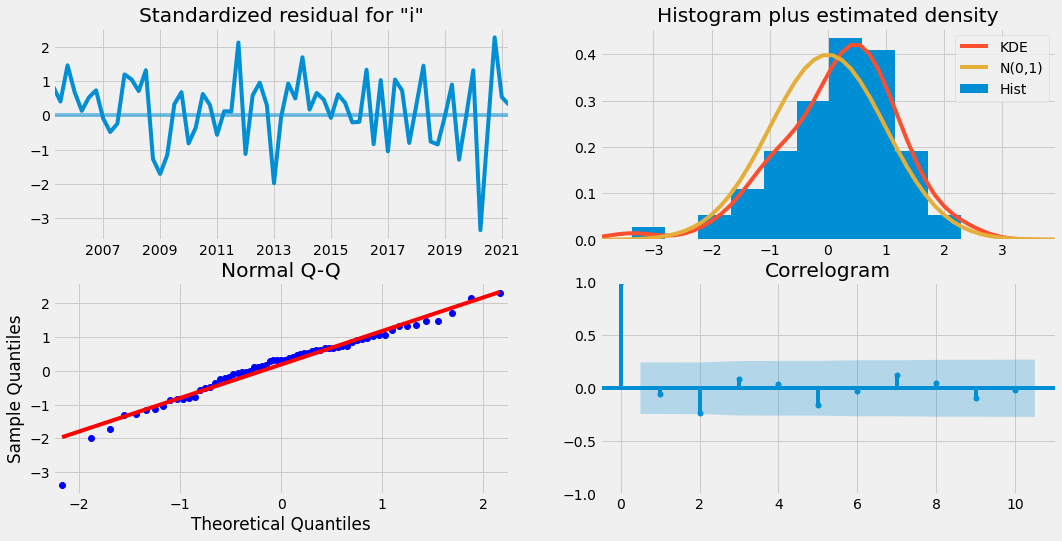

In [175]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

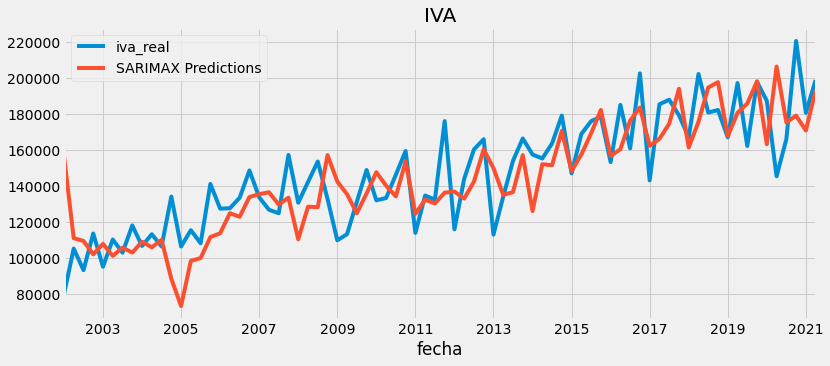

In [176]:
predictions = results.predict(start=0, end=len(iva)-1, dynamic=False, typ='levels', exog=pib2).rename('SARIMAX Predictions')
title = 'IVA'
ax = iva.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [177]:
r2_score(iva, predictions)
evaluation_results = pd.DataFrame({'r2_score': r2_score(iva, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(iva, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(iva, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - iva)/np.abs(iva))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0  0.547705         15527.125385        4.215500e+08   

   mean_absolute_percentage_error  
0                       11.371329

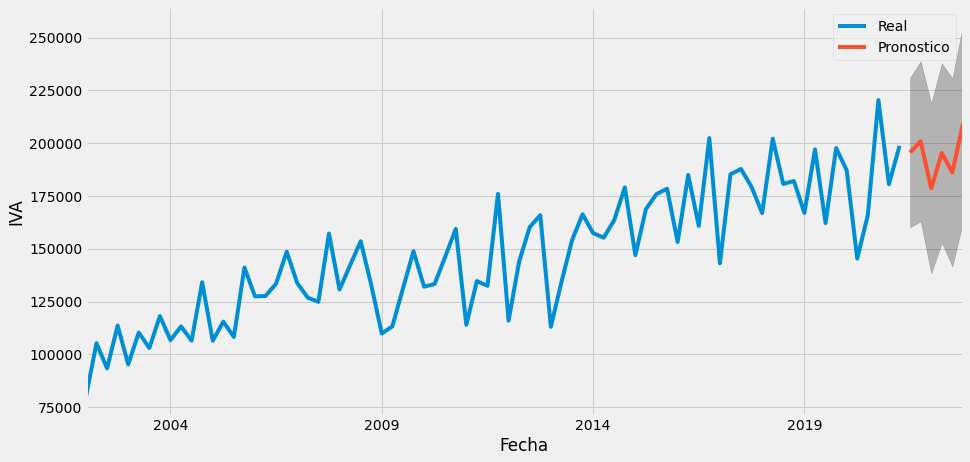

In [178]:
pred_f = results.get_forecast(steps=6, exog=pib2x)
pred_ci = pred_f.conf_int()
ax = iva.plot(label='Real', figsize=(14, 7))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IVA')
plt.legend()
plt.show()

In [179]:
x=pred_f.predicted_mean
x.to_csv('arima_iva.csv')

Cierro esta *notebook* sin conclusiones. Pueden consultarlas en la respectiva publicación [aquí](https://gonzalezhomar.netlify.app/post/pronostico_2_autoarima/).